### Comparing Online Portfolio Management Algorithms using the Experiments of Agarwal et al. 2007
- In this notebook we analyze the performance of several online portfolio management algorithms using the 'universal-portfolios' package available in Python 
- Our experiments mirror those found in Newton Method Based portfolio management 
- There are two major categories of algorithm under examination: 'Follow the Winner' algorithms, and 'Follow the Loser'
    - Follow the Winner: UP, EG, ONS
    - Follow the Loser: PAMR, CWMR, OLMAR, RMR 
- Benchmark algorithms that we compare performance against are the UCRP, and BCRP
- Extensions: Running more algorithms (Pattern-matching Algorithms)

In [3]:
%matplotlib inline
from __future__ import division
import pandas as pd 
import numpy as np
import os 

from universal import tools
from universal import algos
import logging
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [4]:
# note what versions we are on:
import sys
print('Python: '+sys.version)
print('Pandas: '+pd.__version__)
import pkg_resources
print('universal-portfolios: '+pkg_resources.get_distribution("universal-portfolios").version)

Python: 3.5.2 (default, Sep 14 2017, 22:51:06) 
[GCC 5.4.0 20160609]
Pandas: 0.21.0
universal-portfolios: 0.3.2


#### Data Preprocessing 

In [5]:
date_conv = lambda x: pd.to_datetime(x)

def data_reader(tickers, source, start_date, end_date = None):
    '''
    function that reads data from yahoo finance/ quandl data sources
    inputs:
    tickers -- stock tickers
    source -- 'quandl', 'yahoo'
    start_date -- start of pricing information
    end_date -- end of pricing information 
    returns:
    '''
    data = DataReader(tickers, source, start_date, end_date)
    return data 

def tradable_stocks():
    '''
    List of S&P500 stocks that contain a 30 year price history 
    '''
    return ['AAPL','ABT','AET','ARNC','AXP','BAC','BCR','BDX','CI','CLX','CMC','CMI','CRS','CSX','DIS','DUK','EMR',
            'FDX','GE','GIS','GPC','HON','HPQ','IBM','IFF','INTC','KO','LLY','LNC','MCD','MEI','NEE','NEM','SHW','SLB',
            'TAP','TGT','TXT','WFC','WMB'
           ]

def tradable_csvs():
    '''
    List of S&P500 csv files available. All stocks contain a 30 year price history. This allows one to avoid API call limits
    '''
    return ['AAPL.csv','ABT.csv','AET.csv','ARNC.csv','AXP.csv','BAC.csv','BCR.csv','BDX.csv','CI.csv','CLX.csv','CMC.csv',
            'CMI.csv','CRS.csv','CSX.csv','DIS.csv','DUK.csv','EMR.csv','FDX.csv','GE.csv','GIS.csv','GPC.csv','HON.csv',
            'HPQ.csv','IBM.csv','IFF.csv','INTC.csv','KO.csv','LLY.csv','LNC.csv','MCD.csv','MEI.csv','NEE.csv','NEM.csv','SHW.csv',
            'SLB.csv','TAP.csv','TGT.csv','TXT.csv','WFC.csv','WMB.csv'
           ]

def stock_df(n_stocks, start_date, end_date, csv = None):
    '''
    function that takes as input a portolio size n and returns a dataframe that contains a number of stocks  
    '''
    # select n stock csv files 
    if csv != None:
        filenames = csv
    else:
        filenames = tradable_csvs()[0:n_stocks]
    # construct empty data frame to hold financial data
    ret_df = pd.DataFrame()
    price_df = pd.DataFrame()
    for f in filenames:
        series = pd.read_csv(os.path.join('~','972project','data' , f))
        series['Date'] = series['Date'].apply(date_conv)
        series = series.set_index('Date')
        series = series['Adj Close']
        series = series.loc[(series.index<=end_date) & (series.index >= start_date)].astype('float')
        series_ret = series.iloc[0:-1].as_matrix()/series.iloc[1:].as_matrix()
        ret_df[f.split('.')[0]] = series_ret
        price_df[f.split('.')[0]] = series
    return ret_df, price_df  

In [6]:
# construct data frame that contains returns data for 40 stocks 
n = 40
start_date = pd.to_datetime('2010-01-10')
end_date = pd.to_datetime('2017-09-20')
returns_df, price_df = stock_df(n, start_date, end_date)

In [7]:
returns_df.head()

,AAPL,ABT,AET,ARNC,AXP,BAC,BCR,BDX,CI,CLX,...,MEI,NEE,NEM,SHW,SLB,TAP,TGT,TXT,WFC,WMB
0,1.011506,1.002900,1.069585,1.124355,0.986911,1.034841,1.009943,1.015016,1.022715,0.998535,...,1.009804,1.024941,1.034213,1.003534,1.015233,0.996458,1.017025,1.006563,1.025641,1.030262
1,0.986091,0.990595,0.995447,0.971214,0.996916,0.984356,0.973738,0.996774,1.002469,0.991927,...,0.972045,0.996505,0.995282,0.987371,0.982216,0.996031,1.000000,1.019599,0.982505,0.999084
2,1.005825,0.998916,0.978988,1.010752,0.987582,0.988109,0.988988,1.005971,0.991297,1.000646,...,1.016234,1.029794,1.006815,0.994218,0.993828,0.994736,0.984830,0.917947,0.985857,1.005991
3,1.016996,0.997477,1.001595,1.011517,1.006841,1.034440,1.011256,1.009831,0.998100,1.011440,...,1.027523,0.989317,1.017013,1.022639,1.006494,1.009075,0.998605,1.041591,1.032407,1.015442
4,0.957636,0.987367,0.960196,1.000640,0.986732,0.996323,0.985566,0.987062,0.971519,0.995283,...,0.996675,0.993319,0.982866,0.996968,0.998590,1.013459,0.979882,0.952132,0.992928,0.925108


In [8]:
price_df.head()

,AAPL,ABT,AET,ARNC,AXP,BAC,BCR,BDX,CI,CLX,...,MEI,NEE,NEM,SHW,SLB,TAP,TGT,TXT,WFC,WMB
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-11,27.003820,21.532736,30.029846,36.411705,36.933857,15.913613,77.263260,67.476524,37.181705,48.520897,...,10.687086,40.495270,44.774933,53.846889,60.504143,37.448517,40.794662,21.023281,23.909105,12.995709
2010-01-12,26.696650,21.470472,28.076166,32.384525,37.423706,15.377831,76.502563,66.478264,36.355896,48.592091,...,10.583330,39.509838,43.293732,53.657272,59.596336,37.581631,40.111771,20.886204,23.311371,12.613988
2010-01-13,27.073221,21.674320,28.204578,33.344368,37.539482,15.622222,78.565857,66.693405,36.266354,48.987583,...,10.887694,39.648411,43.498966,54.343559,60.675404,37.731388,40.111771,20.484732,23.726467,12.625559
2010-01-14,26.916422,21.697838,28.809944,32.989651,38.011509,15.810215,79.440628,66.297562,36.584740,48.955956,...,10.713769,38.501308,43.204514,54.659615,61.052204,37.931072,40.729626,22.315823,24.066833,12.550372
2010-01-15,26.466595,21.752720,28.764076,32.614048,37.753227,15.283833,78.556381,65.652153,36.654381,48.402237,...,10.426793,38.917042,42.481766,53.449577,60.658264,37.589947,40.786522,21.424755,23.311371,12.359512


Text(0.5,1,'Daily Stock Returns')

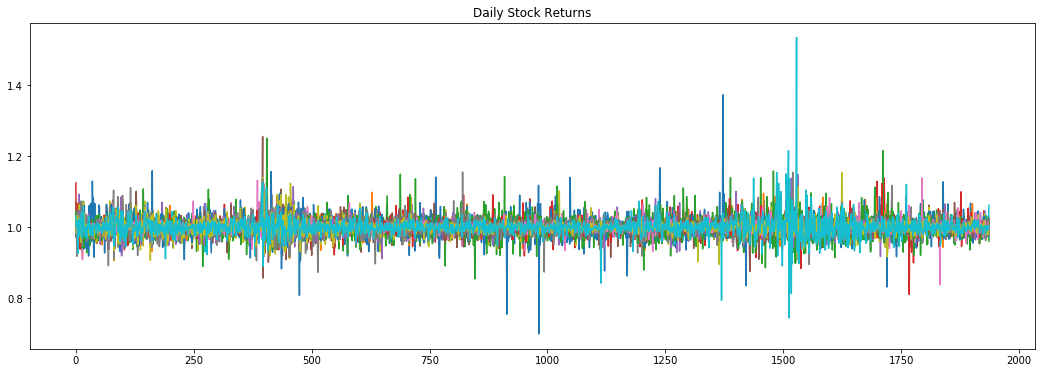

In [9]:
returns_df.plot(figsize=(18,6), legend = False)
plt.title('Daily Stock Returns')

Text(0.5,1,'Adjusted Closing Price')

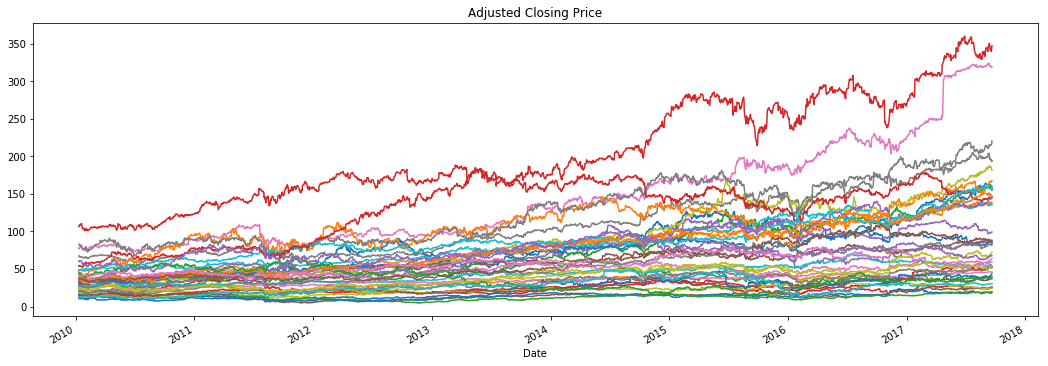

In [10]:
price_df.plot(figsize = (18,6), legend = False)
plt.title('Adjusted Closing Price')

In [11]:
# stocks in data frame
price_df.columns

Index(['AAPL', 'ABT', 'AET', 'ARNC', 'AXP', 'BAC', 'BCR', 'BDX', 'CI', 'CLX',
       'CMC', 'CMI', 'CRS', 'CSX', 'DIS', 'DUK', 'EMR', 'FDX', 'GE', 'GIS',
       'GPC', 'HON', 'HPQ', 'IBM', 'IFF', 'INTC', 'KO', 'LLY', 'LNC', 'MCD',
       'MEI', 'NEE', 'NEM', 'SHW', 'SLB', 'TAP', 'TGT', 'TXT', 'WFC', 'WMB'],
      dtype='object')

In [12]:
#### Initiate Algorithms for Testing 

algorithms = [
algos.BCRP(),
algos.EG(),
algos.ONS(),
algos.OLMAR(window=5, eps = 10),
algos.PAMR(),
algos.CWMR(),
algos.Anticor()
]

# need to fix bug in code for UP algorithm and BNN algorithm

#### Experiment 1: Mean APY Versus Portfolio Size 

In [13]:
portfolio_size = [10, 15, 20, 25, 30, 35, 40]
algorithms_col = ['BCRP', 'EG', 'ONS', 'OLMAR', 'PAMR', 'CWMR', 'ANTICOR']
exp1_df = pd.DataFrame(data = None, index = portfolio_size, columns = algorithms_col)
#apy = np.zeros((len(portfolio_size), len(algorithms_col)))

In [14]:
exp1_df.head()

,BCRP,EG,ONS,OLMAR,PAMR,CWMR,ANTICOR
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
portfolio_bundles=[[price_df.columns.to_series().sample(size) for _ in range(20)] for size in portfolio_size]

In [57]:
for i in range(len(algorithms)):
    for j in range(len(portfolio_size)):
        mapy=0
        for portfolio in portfolio_bundles[j]:
            if algorithms[i].PRICE_TYPE =="raw":
                data = price_df[portfolio]
            elif algorithms[i].PRICE_TYPE =="ratio":
                data = returns_df[portfolio]
            else:
                data = returns_df[portfolio]
            
            result = algorithms[i].run(data)
            mapy += result.annualized_return
        exp1_df.loc[portfolio_size[j], algorithms_col[i]] = mapy/len(portfolio_bundles[j])

2017-12-10 16:20:02,986 Running BCRP...
2017-12-10 16:20:03,028 BCRP finished successfully.
2017-12-10 16:20:03,039 Running BCRP...
2017-12-10 16:20:03,078 BCRP finished successfully.
2017-12-10 16:20:03,089 Running BCRP...
2017-12-10 16:20:03,122 BCRP finished successfully.
2017-12-10 16:20:03,133 Running BCRP...
2017-12-10 16:20:03,180 BCRP finished successfully.
2017-12-10 16:20:03,192 Running BCRP...
2017-12-10 16:20:03,230 BCRP finished successfully.
2017-12-10 16:20:03,241 Running BCRP...
2017-12-10 16:20:03,284 BCRP finished successfully.
2017-12-10 16:20:03,295 Running BCRP...
2017-12-10 16:20:03,323 BCRP finished successfully.
2017-12-10 16:20:03,334 Running BCRP...
2017-12-10 16:20:03,374 BCRP finished successfully.
2017-12-10 16:20:03,385 Running BCRP...
2017-12-10 16:20:03,423 BCRP finished successfully.
2017-12-10 16:20:03,434 Running BCRP...
2017-12-10 16:20:03,468 BCRP finished successfully.
2017-12-10 16:20:03,479 Running BCRP...
2017-12-10 16:20:03,518 BCRP finished su

2017-12-10 16:20:11,060 BCRP finished successfully.
2017-12-10 16:20:11,078 Running BCRP...
2017-12-10 16:20:11,199 BCRP finished successfully.
2017-12-10 16:20:11,216 Running BCRP...
2017-12-10 16:20:11,352 BCRP finished successfully.
2017-12-10 16:20:11,370 Running BCRP...
2017-12-10 16:20:11,493 BCRP finished successfully.
2017-12-10 16:20:11,510 Running BCRP...
2017-12-10 16:20:11,617 BCRP finished successfully.
2017-12-10 16:20:11,634 Running BCRP...
2017-12-10 16:20:11,754 BCRP finished successfully.
2017-12-10 16:20:11,771 Running BCRP...
2017-12-10 16:20:11,907 BCRP finished successfully.
2017-12-10 16:20:11,927 Running BCRP...
2017-12-10 16:20:12,062 BCRP finished successfully.
2017-12-10 16:20:12,079 Running BCRP...
2017-12-10 16:20:12,200 BCRP finished successfully.
2017-12-10 16:20:12,217 Running BCRP...
2017-12-10 16:20:12,372 BCRP finished successfully.
2017-12-10 16:20:12,389 Running BCRP...
2017-12-10 16:20:12,511 BCRP finished successfully.
2017-12-10 16:20:12,529 Runn

2017-12-10 16:20:28,855 EG finished successfully.
2017-12-10 16:20:28,864 Running EG...
2017-12-10 16:20:28,869 Progress: 0.0%...
2017-12-10 16:20:28,987 Progress: 10.0%...
2017-12-10 16:20:29,105 Progress: 20.0%...
2017-12-10 16:20:29,224 Progress: 30.0%...
2017-12-10 16:20:29,341 Progress: 40.0%...
2017-12-10 16:20:29,459 Progress: 50.0%...
2017-12-10 16:20:29,577 Progress: 60.0%...
2017-12-10 16:20:29,695 Progress: 70.0%...
2017-12-10 16:20:29,812 Progress: 80.0%...
2017-12-10 16:20:29,931 Progress: 90.0%...
2017-12-10 16:20:30,048 EG finished successfully.
2017-12-10 16:20:30,056 Running EG...
2017-12-10 16:20:30,061 Progress: 0.0%...
2017-12-10 16:20:30,178 Progress: 10.0%...
2017-12-10 16:20:30,296 Progress: 20.0%...
2017-12-10 16:20:30,414 Progress: 30.0%...
2017-12-10 16:20:30,531 Progress: 40.0%...
2017-12-10 16:20:30,648 Progress: 50.0%...
2017-12-10 16:20:30,766 Progress: 60.0%...
2017-12-10 16:20:30,883 Progress: 70.0%...
2017-12-10 16:20:31,001 Progress: 80.0%...
2017-12-1

2017-12-10 16:20:48,147 Progress: 90.0%...
2017-12-10 16:20:48,264 EG finished successfully.
2017-12-10 16:20:48,274 Running EG...
2017-12-10 16:20:48,280 Progress: 0.0%...
2017-12-10 16:20:48,402 Progress: 10.0%...
2017-12-10 16:20:48,522 Progress: 20.0%...
2017-12-10 16:20:48,642 Progress: 30.0%...
2017-12-10 16:20:48,761 Progress: 40.0%...
2017-12-10 16:20:48,881 Progress: 50.0%...
2017-12-10 16:20:49,000 Progress: 60.0%...
2017-12-10 16:20:49,119 Progress: 70.0%...
2017-12-10 16:20:49,239 Progress: 80.0%...
2017-12-10 16:20:49,359 Progress: 90.0%...
2017-12-10 16:20:49,478 EG finished successfully.
2017-12-10 16:20:49,488 Running EG...
2017-12-10 16:20:49,494 Progress: 0.0%...
2017-12-10 16:20:49,613 Progress: 10.0%...
2017-12-10 16:20:49,732 Progress: 20.0%...
2017-12-10 16:20:49,850 Progress: 30.0%...
2017-12-10 16:20:49,968 Progress: 40.0%...
2017-12-10 16:20:50,086 Progress: 50.0%...
2017-12-10 16:20:50,205 Progress: 60.0%...
2017-12-10 16:20:50,322 Progress: 70.0%...
2017-12-1

2017-12-10 16:21:07,189 Progress: 80.0%...
2017-12-10 16:21:07,308 Progress: 90.0%...
2017-12-10 16:21:07,424 EG finished successfully.
2017-12-10 16:21:07,434 Running EG...
2017-12-10 16:21:07,441 Progress: 0.0%...
2017-12-10 16:21:07,559 Progress: 10.0%...
2017-12-10 16:21:07,678 Progress: 20.0%...
2017-12-10 16:21:07,796 Progress: 30.0%...
2017-12-10 16:21:07,913 Progress: 40.0%...
2017-12-10 16:21:08,031 Progress: 50.0%...
2017-12-10 16:21:08,150 Progress: 60.0%...
2017-12-10 16:21:08,268 Progress: 70.0%...
2017-12-10 16:21:08,386 Progress: 80.0%...
2017-12-10 16:21:08,505 Progress: 90.0%...
2017-12-10 16:21:08,622 EG finished successfully.
2017-12-10 16:21:08,632 Running EG...
2017-12-10 16:21:08,641 Progress: 0.0%...
2017-12-10 16:21:08,761 Progress: 10.0%...
2017-12-10 16:21:08,878 Progress: 20.0%...
2017-12-10 16:21:08,997 Progress: 30.0%...
2017-12-10 16:21:09,115 Progress: 40.0%...
2017-12-10 16:21:09,233 Progress: 50.0%...
2017-12-10 16:21:09,352 Progress: 60.0%...
2017-12-1

2017-12-10 16:21:26,294 Progress: 70.0%...
2017-12-10 16:21:26,413 Progress: 80.0%...
2017-12-10 16:21:26,532 Progress: 90.0%...
2017-12-10 16:21:26,649 EG finished successfully.
2017-12-10 16:21:26,660 Running EG...
2017-12-10 16:21:26,668 Progress: 0.0%...
2017-12-10 16:21:26,787 Progress: 10.0%...
2017-12-10 16:21:26,905 Progress: 20.0%...
2017-12-10 16:21:27,025 Progress: 30.0%...
2017-12-10 16:21:27,143 Progress: 40.0%...
2017-12-10 16:21:27,262 Progress: 50.0%...
2017-12-10 16:21:27,381 Progress: 60.0%...
2017-12-10 16:21:27,500 Progress: 70.0%...
2017-12-10 16:21:27,619 Progress: 80.0%...
2017-12-10 16:21:27,739 Progress: 90.0%...
2017-12-10 16:21:27,856 EG finished successfully.
2017-12-10 16:21:27,868 Running EG...
2017-12-10 16:21:27,876 Progress: 0.0%...
2017-12-10 16:21:27,994 Progress: 10.0%...
2017-12-10 16:21:28,112 Progress: 20.0%...
2017-12-10 16:21:28,231 Progress: 30.0%...
2017-12-10 16:21:28,348 Progress: 40.0%...
2017-12-10 16:21:28,467 Progress: 50.0%...
2017-12-1

2017-12-10 16:21:45,498 Progress: 60.0%...
2017-12-10 16:21:45,616 Progress: 70.0%...
2017-12-10 16:21:45,734 Progress: 80.0%...
2017-12-10 16:21:45,852 Progress: 90.0%...
2017-12-10 16:21:45,970 EG finished successfully.
2017-12-10 16:21:45,982 Running EG...
2017-12-10 16:21:45,991 Progress: 0.0%...
2017-12-10 16:21:46,108 Progress: 10.0%...
2017-12-10 16:21:46,226 Progress: 20.0%...
2017-12-10 16:21:46,344 Progress: 30.0%...
2017-12-10 16:21:46,461 Progress: 40.0%...
2017-12-10 16:21:46,579 Progress: 50.0%...
2017-12-10 16:21:46,697 Progress: 60.0%...
2017-12-10 16:21:46,815 Progress: 70.0%...
2017-12-10 16:21:46,933 Progress: 80.0%...
2017-12-10 16:21:47,051 Progress: 90.0%...
2017-12-10 16:21:47,168 EG finished successfully.
2017-12-10 16:21:47,181 Running EG...
2017-12-10 16:21:47,189 Progress: 0.0%...
2017-12-10 16:21:47,307 Progress: 10.0%...
2017-12-10 16:21:47,425 Progress: 20.0%...
2017-12-10 16:21:47,543 Progress: 30.0%...
2017-12-10 16:21:47,660 Progress: 40.0%...
2017-12-1

2017-12-10 16:22:04,649 Progress: 50.0%...
2017-12-10 16:22:04,769 Progress: 60.0%...
2017-12-10 16:22:04,887 Progress: 70.0%...
2017-12-10 16:22:05,005 Progress: 80.0%...
2017-12-10 16:22:05,124 Progress: 90.0%...
2017-12-10 16:22:05,240 EG finished successfully.
2017-12-10 16:22:05,254 Running EG...
2017-12-10 16:22:05,264 Progress: 0.0%...
2017-12-10 16:22:05,382 Progress: 10.0%...
2017-12-10 16:22:05,500 Progress: 20.0%...
2017-12-10 16:22:05,618 Progress: 30.0%...
2017-12-10 16:22:05,735 Progress: 40.0%...
2017-12-10 16:22:05,854 Progress: 50.0%...
2017-12-10 16:22:05,972 Progress: 60.0%...
2017-12-10 16:22:06,089 Progress: 70.0%...
2017-12-10 16:22:06,207 Progress: 80.0%...
2017-12-10 16:22:06,325 Progress: 90.0%...
2017-12-10 16:22:06,442 EG finished successfully.
2017-12-10 16:22:06,456 Running EG...
2017-12-10 16:22:06,465 Progress: 0.0%...
2017-12-10 16:22:06,583 Progress: 10.0%...
2017-12-10 16:22:06,701 Progress: 20.0%...
2017-12-10 16:22:06,828 Progress: 30.0%...
2017-12-1

2017-12-10 16:22:24,034 Progress: 40.0%...
2017-12-10 16:22:24,153 Progress: 50.0%...
2017-12-10 16:22:24,271 Progress: 60.0%...
2017-12-10 16:22:24,390 Progress: 70.0%...
2017-12-10 16:22:24,509 Progress: 80.0%...
2017-12-10 16:22:24,628 Progress: 90.0%...
2017-12-10 16:22:24,746 EG finished successfully.
2017-12-10 16:22:24,761 Running EG...
2017-12-10 16:22:24,771 Progress: 0.0%...
2017-12-10 16:22:24,890 Progress: 10.0%...
2017-12-10 16:22:25,009 Progress: 20.0%...
2017-12-10 16:22:25,128 Progress: 30.0%...
2017-12-10 16:22:25,246 Progress: 40.0%...
2017-12-10 16:22:25,365 Progress: 50.0%...
2017-12-10 16:22:25,483 Progress: 60.0%...
2017-12-10 16:22:25,602 Progress: 70.0%...
2017-12-10 16:22:25,721 Progress: 80.0%...
2017-12-10 16:22:25,839 Progress: 90.0%...
2017-12-10 16:22:25,957 EG finished successfully.
2017-12-10 16:22:25,973 Running EG...
2017-12-10 16:22:25,984 Progress: 0.0%...
2017-12-10 16:22:26,104 Progress: 10.0%...
2017-12-10 16:22:26,223 Progress: 20.0%...
2017-12-1

2017-12-10 16:22:43,449 Progress: 30.0%...
2017-12-10 16:22:43,568 Progress: 40.0%...
2017-12-10 16:22:43,689 Progress: 50.0%...
2017-12-10 16:22:43,809 Progress: 60.0%...
2017-12-10 16:22:43,929 Progress: 70.0%...
2017-12-10 16:22:44,048 Progress: 80.0%...
2017-12-10 16:22:44,165 Progress: 90.0%...
2017-12-10 16:22:44,282 EG finished successfully.
2017-12-10 16:22:44,297 Running EG...
2017-12-10 16:22:44,308 Progress: 0.0%...
2017-12-10 16:22:44,427 Progress: 10.0%...
2017-12-10 16:22:44,545 Progress: 20.0%...
2017-12-10 16:22:44,663 Progress: 30.0%...
2017-12-10 16:22:44,781 Progress: 40.0%...
2017-12-10 16:22:44,900 Progress: 50.0%...
2017-12-10 16:22:45,019 Progress: 60.0%...
2017-12-10 16:22:45,138 Progress: 70.0%...
2017-12-10 16:22:45,257 Progress: 80.0%...
2017-12-10 16:22:45,376 Progress: 90.0%...
2017-12-10 16:22:45,493 EG finished successfully.
2017-12-10 16:22:45,509 Running EG...
2017-12-10 16:22:45,521 Progress: 0.0%...
2017-12-10 16:22:45,639 Progress: 10.0%...
2017-12-1

2017-12-10 16:23:02,845 Progress: 20.0%...
2017-12-10 16:23:02,964 Progress: 30.0%...
2017-12-10 16:23:03,082 Progress: 40.0%...
2017-12-10 16:23:03,200 Progress: 50.0%...
2017-12-10 16:23:03,319 Progress: 60.0%...
2017-12-10 16:23:03,436 Progress: 70.0%...
2017-12-10 16:23:03,554 Progress: 80.0%...
2017-12-10 16:23:03,672 Progress: 90.0%...
2017-12-10 16:23:03,789 EG finished successfully.
2017-12-10 16:23:03,806 Running EG...
2017-12-10 16:23:03,818 Progress: 0.0%...
2017-12-10 16:23:03,939 Progress: 10.0%...
2017-12-10 16:23:04,058 Progress: 20.0%...
2017-12-10 16:23:04,176 Progress: 30.0%...
2017-12-10 16:23:04,295 Progress: 40.0%...
2017-12-10 16:23:04,414 Progress: 50.0%...
2017-12-10 16:23:04,533 Progress: 60.0%...
2017-12-10 16:23:04,651 Progress: 70.0%...
2017-12-10 16:23:04,771 Progress: 80.0%...
2017-12-10 16:23:04,892 Progress: 90.0%...
2017-12-10 16:23:05,009 EG finished successfully.
2017-12-10 16:23:05,026 Running EG...
2017-12-10 16:23:05,038 Progress: 0.0%...
2017-12-1

2017-12-10 16:23:36,517 Progress: 0.0%...
2017-12-10 16:23:36,759 Progress: 10.0%...
2017-12-10 16:23:37,017 Progress: 20.0%...
2017-12-10 16:23:37,268 Progress: 30.0%...
2017-12-10 16:23:37,530 Progress: 40.0%...
2017-12-10 16:23:37,814 Progress: 50.0%...
2017-12-10 16:23:38,117 Progress: 60.0%...
2017-12-10 16:23:38,409 Progress: 70.0%...
2017-12-10 16:23:38,693 Progress: 80.0%...
2017-12-10 16:23:38,985 Progress: 90.0%...
2017-12-10 16:23:39,255 ONS finished successfully.
2017-12-10 16:23:39,267 Running ONS...
2017-12-10 16:23:39,275 Progress: 0.0%...
2017-12-10 16:23:39,556 Progress: 10.0%...
2017-12-10 16:23:39,819 Progress: 20.0%...
2017-12-10 16:23:40,050 Progress: 30.0%...
2017-12-10 16:23:40,298 Progress: 40.0%...
2017-12-10 16:23:40,537 Progress: 50.0%...
2017-12-10 16:23:40,774 Progress: 60.0%...
2017-12-10 16:23:41,012 Progress: 70.0%...
2017-12-10 16:23:41,273 Progress: 80.0%...
2017-12-10 16:23:41,566 Progress: 90.0%...
2017-12-10 16:23:41,852 ONS finished successfully.
2

2017-12-10 16:24:18,521 ONS finished successfully.
2017-12-10 16:24:18,532 Running ONS...
2017-12-10 16:24:18,541 Progress: 0.0%...
2017-12-10 16:24:18,786 Progress: 10.0%...
2017-12-10 16:24:19,012 Progress: 20.0%...
2017-12-10 16:24:19,254 Progress: 30.0%...
2017-12-10 16:24:19,541 Progress: 40.0%...
2017-12-10 16:24:19,837 Progress: 50.0%...
2017-12-10 16:24:20,140 Progress: 60.0%...
2017-12-10 16:24:20,439 Progress: 70.0%...
2017-12-10 16:24:20,739 Progress: 80.0%...
2017-12-10 16:24:21,001 Progress: 90.0%...
2017-12-10 16:24:21,261 ONS finished successfully.
2017-12-10 16:24:21,272 Running ONS...
2017-12-10 16:24:21,281 Progress: 0.0%...
2017-12-10 16:24:21,525 Progress: 10.0%...
2017-12-10 16:24:21,756 Progress: 20.0%...
2017-12-10 16:24:22,022 Progress: 30.0%...
2017-12-10 16:24:22,310 Progress: 40.0%...
2017-12-10 16:24:22,602 Progress: 50.0%...
2017-12-10 16:24:22,905 Progress: 60.0%...
2017-12-10 16:24:23,198 Progress: 70.0%...
2017-12-10 16:24:23,496 Progress: 80.0%...
2017-

2017-12-10 16:25:04,259 Progress: 80.0%...
2017-12-10 16:25:04,639 Progress: 90.0%...
2017-12-10 16:25:05,000 ONS finished successfully.
2017-12-10 16:25:05,014 Running ONS...
2017-12-10 16:25:05,025 Progress: 0.0%...
2017-12-10 16:25:05,320 Progress: 10.0%...
2017-12-10 16:25:05,660 Progress: 20.0%...
2017-12-10 16:25:05,997 Progress: 30.0%...
2017-12-10 16:25:06,352 Progress: 40.0%...
2017-12-10 16:25:06,719 Progress: 50.0%...
2017-12-10 16:25:07,089 Progress: 60.0%...
2017-12-10 16:25:07,491 Progress: 70.0%...
2017-12-10 16:25:07,858 Progress: 80.0%...
2017-12-10 16:25:08,224 Progress: 90.0%...
2017-12-10 16:25:08,583 ONS finished successfully.
2017-12-10 16:25:08,596 Running ONS...
2017-12-10 16:25:08,607 Progress: 0.0%...
2017-12-10 16:25:08,916 Progress: 10.0%...
2017-12-10 16:25:09,272 Progress: 20.0%...
2017-12-10 16:25:09,594 Progress: 30.0%...
2017-12-10 16:25:09,939 Progress: 40.0%...
2017-12-10 16:25:10,274 Progress: 50.0%...
2017-12-10 16:25:10,620 Progress: 60.0%...
2017-

2017-12-10 16:26:01,534 Progress: 60.0%...
2017-12-10 16:26:01,931 Progress: 70.0%...
2017-12-10 16:26:02,326 Progress: 80.0%...
2017-12-10 16:26:02,717 Progress: 90.0%...
2017-12-10 16:26:03,112 ONS finished successfully.
2017-12-10 16:26:03,127 Running ONS...
2017-12-10 16:26:03,137 Progress: 0.0%...
2017-12-10 16:26:03,498 Progress: 10.0%...
2017-12-10 16:26:03,842 Progress: 20.0%...
2017-12-10 16:26:04,233 Progress: 30.0%...
2017-12-10 16:26:04,618 Progress: 40.0%...
2017-12-10 16:26:05,011 Progress: 50.0%...
2017-12-10 16:26:05,410 Progress: 60.0%...
2017-12-10 16:26:05,796 Progress: 70.0%...
2017-12-10 16:26:06,189 Progress: 80.0%...
2017-12-10 16:26:06,576 Progress: 90.0%...
2017-12-10 16:26:06,972 ONS finished successfully.
2017-12-10 16:26:06,986 Running ONS...
2017-12-10 16:26:06,998 Progress: 0.0%...
2017-12-10 16:26:07,354 Progress: 10.0%...
2017-12-10 16:26:07,698 Progress: 20.0%...
2017-12-10 16:26:08,090 Progress: 30.0%...
2017-12-10 16:26:08,458 Progress: 40.0%...
2017-

2017-12-10 16:27:04,198 Progress: 40.0%...
2017-12-10 16:27:04,608 Progress: 50.0%...
2017-12-10 16:27:04,999 Progress: 60.0%...
2017-12-10 16:27:05,409 Progress: 70.0%...
2017-12-10 16:27:05,803 Progress: 80.0%...
2017-12-10 16:27:06,211 Progress: 90.0%...
2017-12-10 16:27:06,610 ONS finished successfully.
2017-12-10 16:27:06,627 Running ONS...
2017-12-10 16:27:06,640 Progress: 0.0%...
2017-12-10 16:27:07,007 Progress: 10.0%...
2017-12-10 16:27:07,385 Progress: 20.0%...
2017-12-10 16:27:07,772 Progress: 30.0%...
2017-12-10 16:27:08,190 Progress: 40.0%...
2017-12-10 16:27:08,605 Progress: 50.0%...
2017-12-10 16:27:09,014 Progress: 60.0%...
2017-12-10 16:27:09,425 Progress: 70.0%...
2017-12-10 16:27:09,829 Progress: 80.0%...
2017-12-10 16:27:10,235 Progress: 90.0%...
2017-12-10 16:27:10,642 ONS finished successfully.
2017-12-10 16:27:10,658 Running ONS...
2017-12-10 16:27:10,671 Progress: 0.0%...
2017-12-10 16:27:11,056 Progress: 10.0%...
2017-12-10 16:27:11,449 Progress: 20.0%...
2017-

2017-12-10 16:28:13,668 Progress: 20.0%...
2017-12-10 16:28:14,133 Progress: 30.0%...
2017-12-10 16:28:14,582 Progress: 40.0%...
2017-12-10 16:28:15,045 Progress: 50.0%...
2017-12-10 16:28:15,507 Progress: 60.0%...
2017-12-10 16:28:15,960 Progress: 70.0%...
2017-12-10 16:28:16,435 Progress: 80.0%...
2017-12-10 16:28:16,887 Progress: 90.0%...
2017-12-10 16:28:17,346 ONS finished successfully.
2017-12-10 16:28:17,363 Running ONS...
2017-12-10 16:28:17,377 Progress: 0.0%...
2017-12-10 16:28:17,804 Progress: 10.0%...
2017-12-10 16:28:18,256 Progress: 20.0%...
2017-12-10 16:28:18,722 Progress: 30.0%...
2017-12-10 16:28:19,181 Progress: 40.0%...
2017-12-10 16:28:19,630 Progress: 50.0%...
2017-12-10 16:28:20,084 Progress: 60.0%...
2017-12-10 16:28:20,540 Progress: 70.0%...
2017-12-10 16:28:21,068 Progress: 80.0%...
2017-12-10 16:28:21,559 Progress: 90.0%...
2017-12-10 16:28:22,069 ONS finished successfully.
2017-12-10 16:28:22,086 Running ONS...
2017-12-10 16:28:22,100 Progress: 0.0%...
2017-

2017-12-10 16:29:28,727 Progress: 0.0%...
2017-12-10 16:29:29,209 Progress: 10.0%...
2017-12-10 16:29:29,702 Progress: 20.0%...
2017-12-10 16:29:30,191 Progress: 30.0%...
2017-12-10 16:29:30,693 Progress: 40.0%...
2017-12-10 16:29:31,187 Progress: 50.0%...
2017-12-10 16:29:31,691 Progress: 60.0%...
2017-12-10 16:29:32,212 Progress: 70.0%...
2017-12-10 16:29:32,701 Progress: 80.0%...
2017-12-10 16:29:33,190 Progress: 90.0%...
2017-12-10 16:29:33,688 ONS finished successfully.
2017-12-10 16:29:33,707 Running ONS...
2017-12-10 16:29:33,723 Progress: 0.0%...
2017-12-10 16:29:34,199 Progress: 10.0%...
2017-12-10 16:29:34,685 Progress: 20.0%...
2017-12-10 16:29:35,178 Progress: 30.0%...
2017-12-10 16:29:35,661 Progress: 40.0%...
2017-12-10 16:29:36,144 Progress: 50.0%...
2017-12-10 16:29:36,632 Progress: 60.0%...
2017-12-10 16:29:37,112 Progress: 70.0%...
2017-12-10 16:29:37,597 Progress: 80.0%...
2017-12-10 16:29:38,085 Progress: 90.0%...
2017-12-10 16:29:38,563 ONS finished successfully.
2

2017-12-10 16:31:01,364 ONS finished successfully.
2017-12-10 16:31:01,388 Running ONS...
2017-12-10 16:31:01,425 Progress: 0.0%...
2017-12-10 16:31:02,317 Progress: 10.0%...
2017-12-10 16:31:03,127 Progress: 20.0%...
2017-12-10 16:31:04,026 Progress: 30.0%...
2017-12-10 16:31:04,776 Progress: 40.0%...
2017-12-10 16:31:05,530 Progress: 50.0%...
2017-12-10 16:31:06,293 Progress: 60.0%...
2017-12-10 16:31:07,314 Progress: 70.0%...
2017-12-10 16:31:08,178 Progress: 80.0%...
2017-12-10 16:31:09,451 Progress: 90.0%...
2017-12-10 16:31:10,448 ONS finished successfully.
2017-12-10 16:31:10,473 Running ONS...
2017-12-10 16:31:10,529 Progress: 0.0%...
2017-12-10 16:31:11,215 Progress: 10.0%...
2017-12-10 16:31:11,889 Progress: 20.0%...
2017-12-10 16:31:12,468 Progress: 30.0%...
2017-12-10 16:31:13,034 Progress: 40.0%...
2017-12-10 16:31:13,599 Progress: 50.0%...
2017-12-10 16:31:14,140 Progress: 60.0%...
2017-12-10 16:31:14,687 Progress: 70.0%...
2017-12-10 16:31:15,535 Progress: 80.0%...
2017-

2017-12-10 16:32:36,279 Progress: 80.0%...
2017-12-10 16:32:36,858 Progress: 90.0%...
2017-12-10 16:32:37,416 ONS finished successfully.
2017-12-10 16:32:37,436 Running ONS...
2017-12-10 16:32:37,452 Progress: 0.0%...
2017-12-10 16:32:38,024 Progress: 10.0%...
2017-12-10 16:32:38,568 Progress: 20.0%...
2017-12-10 16:32:39,131 Progress: 30.0%...
2017-12-10 16:32:39,672 Progress: 40.0%...
2017-12-10 16:32:40,217 Progress: 50.0%...
2017-12-10 16:32:40,743 Progress: 60.0%...
2017-12-10 16:32:41,288 Progress: 70.0%...
2017-12-10 16:32:41,872 Progress: 80.0%...
2017-12-10 16:32:42,683 Progress: 90.0%...
2017-12-10 16:32:43,247 ONS finished successfully.
2017-12-10 16:32:43,268 Running ONS...
2017-12-10 16:32:43,285 Progress: 0.0%...
2017-12-10 16:32:44,073 Progress: 10.0%...
2017-12-10 16:32:44,694 Progress: 20.0%...
2017-12-10 16:32:45,237 Progress: 30.0%...
2017-12-10 16:32:45,770 Progress: 40.0%...
2017-12-10 16:32:46,314 Progress: 50.0%...
2017-12-10 16:32:46,907 Progress: 60.0%...
2017-

2017-12-10 16:33:31,138 Progress: 60.0%...
2017-12-10 16:33:31,396 Progress: 70.0%...
2017-12-10 16:33:31,652 Progress: 80.0%...
2017-12-10 16:33:31,910 Progress: 90.0%...
2017-12-10 16:33:32,163 OLMAR finished successfully.
2017-12-10 16:33:32,171 Running OLMAR...
2017-12-10 16:33:32,430 Progress: 10.0%...
2017-12-10 16:33:32,686 Progress: 20.0%...
2017-12-10 16:33:32,945 Progress: 30.0%...
2017-12-10 16:33:33,202 Progress: 40.0%...
2017-12-10 16:33:33,458 Progress: 50.0%...
2017-12-10 16:33:33,716 Progress: 60.0%...
2017-12-10 16:33:33,973 Progress: 70.0%...
2017-12-10 16:33:34,231 Progress: 80.0%...
2017-12-10 16:33:34,488 Progress: 90.0%...
2017-12-10 16:33:34,744 OLMAR finished successfully.
2017-12-10 16:33:34,751 Running OLMAR...
2017-12-10 16:33:35,009 Progress: 10.0%...
2017-12-10 16:33:35,264 Progress: 20.0%...
2017-12-10 16:33:35,524 Progress: 30.0%...
2017-12-10 16:33:35,782 Progress: 40.0%...
2017-12-10 16:33:36,041 Progress: 50.0%...
2017-12-10 16:33:36,299 Progress: 60.0

2017-12-10 16:34:16,008 Progress: 70.0%...
2017-12-10 16:34:16,269 Progress: 80.0%...
2017-12-10 16:34:16,543 Progress: 90.0%...
2017-12-10 16:34:16,803 OLMAR finished successfully.
2017-12-10 16:34:16,812 Running OLMAR...
2017-12-10 16:34:17,071 Progress: 10.0%...
2017-12-10 16:34:17,342 Progress: 20.0%...
2017-12-10 16:34:17,599 Progress: 30.0%...
2017-12-10 16:34:17,860 Progress: 40.0%...
2017-12-10 16:34:18,118 Progress: 50.0%...
2017-12-10 16:34:18,378 Progress: 60.0%...
2017-12-10 16:34:18,638 Progress: 70.0%...
2017-12-10 16:34:18,897 Progress: 80.0%...
2017-12-10 16:34:19,156 Progress: 90.0%...
2017-12-10 16:34:19,414 OLMAR finished successfully.
2017-12-10 16:34:19,422 Running OLMAR...
2017-12-10 16:34:19,692 Progress: 10.0%...
2017-12-10 16:34:19,959 Progress: 20.0%...
2017-12-10 16:34:20,284 Progress: 30.0%...
2017-12-10 16:34:20,548 Progress: 40.0%...
2017-12-10 16:34:20,808 Progress: 50.0%...
2017-12-10 16:34:21,071 Progress: 60.0%...
2017-12-10 16:34:21,345 Progress: 70.0

2017-12-10 16:35:02,796 Progress: 80.0%...
2017-12-10 16:35:03,054 Progress: 90.0%...
2017-12-10 16:35:03,324 OLMAR finished successfully.
2017-12-10 16:35:03,334 Running OLMAR...
2017-12-10 16:35:03,612 Progress: 10.0%...
2017-12-10 16:35:03,877 Progress: 20.0%...
2017-12-10 16:35:04,135 Progress: 30.0%...
2017-12-10 16:35:04,395 Progress: 40.0%...
2017-12-10 16:35:04,660 Progress: 50.0%...
2017-12-10 16:35:04,926 Progress: 60.0%...
2017-12-10 16:35:05,183 Progress: 70.0%...
2017-12-10 16:35:05,449 Progress: 80.0%...
2017-12-10 16:35:05,708 Progress: 90.0%...
2017-12-10 16:35:05,965 OLMAR finished successfully.
2017-12-10 16:35:05,975 Running OLMAR...
2017-12-10 16:35:06,236 Progress: 10.0%...
2017-12-10 16:35:06,494 Progress: 20.0%...
2017-12-10 16:35:06,769 Progress: 30.0%...
2017-12-10 16:35:07,037 Progress: 40.0%...
2017-12-10 16:35:07,299 Progress: 50.0%...
2017-12-10 16:35:07,558 Progress: 60.0%...
2017-12-10 16:35:07,820 Progress: 70.0%...
2017-12-10 16:35:08,084 Progress: 80.0

2017-12-10 16:35:48,354 Progress: 90.0%...
2017-12-10 16:35:48,612 OLMAR finished successfully.
2017-12-10 16:35:48,622 Running OLMAR...
2017-12-10 16:35:48,887 Progress: 10.0%...
2017-12-10 16:35:49,144 Progress: 20.0%...
2017-12-10 16:35:49,404 Progress: 30.0%...
2017-12-10 16:35:49,666 Progress: 40.0%...
2017-12-10 16:35:49,927 Progress: 50.0%...
2017-12-10 16:35:50,186 Progress: 60.0%...
2017-12-10 16:35:50,446 Progress: 70.0%...
2017-12-10 16:35:50,705 Progress: 80.0%...
2017-12-10 16:35:50,964 Progress: 90.0%...
2017-12-10 16:35:51,222 OLMAR finished successfully.
2017-12-10 16:35:51,233 Running OLMAR...
2017-12-10 16:35:51,499 Progress: 10.0%...
2017-12-10 16:35:51,760 Progress: 20.0%...
2017-12-10 16:35:52,018 Progress: 30.0%...
2017-12-10 16:35:52,276 Progress: 40.0%...
2017-12-10 16:35:52,534 Progress: 50.0%...
2017-12-10 16:35:52,793 Progress: 60.0%...
2017-12-10 16:35:53,052 Progress: 70.0%...
2017-12-10 16:35:53,312 Progress: 80.0%...
2017-12-10 16:35:53,571 Progress: 90.0

2017-12-10 16:36:33,151 OLMAR finished successfully.
2017-12-10 16:36:33,163 Running OLMAR...
2017-12-10 16:36:33,431 Progress: 10.0%...
2017-12-10 16:36:33,691 Progress: 20.0%...
2017-12-10 16:36:33,952 Progress: 30.0%...
2017-12-10 16:36:34,212 Progress: 40.0%...
2017-12-10 16:36:34,472 Progress: 50.0%...
2017-12-10 16:36:34,731 Progress: 60.0%...
2017-12-10 16:36:34,989 Progress: 70.0%...
2017-12-10 16:36:35,250 Progress: 80.0%...
2017-12-10 16:36:35,509 Progress: 90.0%...
2017-12-10 16:36:35,767 OLMAR finished successfully.
2017-12-10 16:36:35,779 Running OLMAR...
2017-12-10 16:36:36,044 Progress: 10.0%...
2017-12-10 16:36:36,304 Progress: 20.0%...
2017-12-10 16:36:36,565 Progress: 30.0%...
2017-12-10 16:36:36,824 Progress: 40.0%...
2017-12-10 16:36:37,084 Progress: 50.0%...
2017-12-10 16:36:37,344 Progress: 60.0%...
2017-12-10 16:36:37,604 Progress: 70.0%...
2017-12-10 16:36:37,864 Progress: 80.0%...
2017-12-10 16:36:38,124 Progress: 90.0%...
2017-12-10 16:36:38,384 OLMAR finished

2017-12-10 16:37:18,047 Running OLMAR...
2017-12-10 16:37:18,320 Progress: 10.0%...
2017-12-10 16:37:18,582 Progress: 20.0%...
2017-12-10 16:37:18,843 Progress: 30.0%...
2017-12-10 16:37:19,109 Progress: 40.0%...
2017-12-10 16:37:19,375 Progress: 50.0%...
2017-12-10 16:37:19,640 Progress: 60.0%...
2017-12-10 16:37:19,908 Progress: 70.0%...
2017-12-10 16:37:20,168 Progress: 80.0%...
2017-12-10 16:37:20,439 Progress: 90.0%...
2017-12-10 16:37:20,708 OLMAR finished successfully.
2017-12-10 16:37:20,721 Running OLMAR...
2017-12-10 16:37:20,998 Progress: 10.0%...
2017-12-10 16:37:21,270 Progress: 20.0%...
2017-12-10 16:37:21,539 Progress: 30.0%...
2017-12-10 16:37:21,812 Progress: 40.0%...
2017-12-10 16:37:22,079 Progress: 50.0%...
2017-12-10 16:37:22,356 Progress: 60.0%...
2017-12-10 16:37:22,628 Progress: 70.0%...
2017-12-10 16:37:22,895 Progress: 80.0%...
2017-12-10 16:37:23,160 Progress: 90.0%...
2017-12-10 16:37:23,422 OLMAR finished successfully.
2017-12-10 16:37:23,436 Running OLMAR.

2017-12-10 16:38:03,833 Progress: 10.0%...
2017-12-10 16:38:04,095 Progress: 20.0%...
2017-12-10 16:38:04,356 Progress: 30.0%...
2017-12-10 16:38:04,618 Progress: 40.0%...
2017-12-10 16:38:04,878 Progress: 50.0%...
2017-12-10 16:38:05,138 Progress: 60.0%...
2017-12-10 16:38:05,400 Progress: 70.0%...
2017-12-10 16:38:05,661 Progress: 80.0%...
2017-12-10 16:38:05,922 Progress: 90.0%...
2017-12-10 16:38:06,181 OLMAR finished successfully.
2017-12-10 16:38:06,194 Running OLMAR...
2017-12-10 16:38:06,463 Progress: 10.0%...
2017-12-10 16:38:06,735 Progress: 20.0%...
2017-12-10 16:38:07,001 Progress: 30.0%...
2017-12-10 16:38:07,265 Progress: 40.0%...
2017-12-10 16:38:07,526 Progress: 50.0%...
2017-12-10 16:38:07,790 Progress: 60.0%...
2017-12-10 16:38:08,056 Progress: 70.0%...
2017-12-10 16:38:08,321 Progress: 80.0%...
2017-12-10 16:38:08,584 Progress: 90.0%...
2017-12-10 16:38:08,845 OLMAR finished successfully.
2017-12-10 16:38:08,859 Running OLMAR...
2017-12-10 16:38:09,127 Progress: 10.0

2017-12-10 16:38:49,149 Progress: 20.0%...
2017-12-10 16:38:49,410 Progress: 30.0%...
2017-12-10 16:38:49,672 Progress: 40.0%...
2017-12-10 16:38:49,931 Progress: 50.0%...
2017-12-10 16:38:50,193 Progress: 60.0%...
2017-12-10 16:38:50,453 Progress: 70.0%...
2017-12-10 16:38:50,714 Progress: 80.0%...
2017-12-10 16:38:50,976 Progress: 90.0%...
2017-12-10 16:38:51,234 OLMAR finished successfully.
2017-12-10 16:38:51,249 Running OLMAR...
2017-12-10 16:38:51,516 Progress: 10.0%...
2017-12-10 16:38:51,779 Progress: 20.0%...
2017-12-10 16:38:52,039 Progress: 30.0%...
2017-12-10 16:38:52,300 Progress: 40.0%...
2017-12-10 16:38:52,558 Progress: 50.0%...
2017-12-10 16:38:52,821 Progress: 60.0%...
2017-12-10 16:38:53,081 Progress: 70.0%...
2017-12-10 16:38:53,343 Progress: 80.0%...
2017-12-10 16:38:53,606 Progress: 90.0%...
2017-12-10 16:38:53,863 OLMAR finished successfully.
2017-12-10 16:38:53,878 Running OLMAR...
2017-12-10 16:38:54,147 Progress: 10.0%...
2017-12-10 16:38:54,407 Progress: 20.0

2017-12-10 16:39:20,223 Progress: 10.0%...
2017-12-10 16:39:20,367 Progress: 20.0%...
2017-12-10 16:39:20,511 Progress: 30.0%...
2017-12-10 16:39:20,655 Progress: 40.0%...
2017-12-10 16:39:20,798 Progress: 50.0%...
2017-12-10 16:39:20,942 Progress: 60.0%...
2017-12-10 16:39:21,084 Progress: 70.0%...
2017-12-10 16:39:21,228 Progress: 80.0%...
2017-12-10 16:39:21,372 Progress: 90.0%...
2017-12-10 16:39:21,514 PAMR finished successfully.
2017-12-10 16:39:21,523 Running PAMR...
2017-12-10 16:39:21,528 Progress: 0.0%...
2017-12-10 16:39:21,671 Progress: 10.0%...
2017-12-10 16:39:21,815 Progress: 20.0%...
2017-12-10 16:39:21,958 Progress: 30.0%...
2017-12-10 16:39:22,100 Progress: 40.0%...
2017-12-10 16:39:22,245 Progress: 50.0%...
2017-12-10 16:39:22,388 Progress: 60.0%...
2017-12-10 16:39:22,531 Progress: 70.0%...
2017-12-10 16:39:22,675 Progress: 80.0%...
2017-12-10 16:39:22,820 Progress: 90.0%...
2017-12-10 16:39:22,963 PAMR finished successfully.
2017-12-10 16:39:22,971 Running PAMR...


2017-12-10 16:39:43,265 PAMR finished successfully.
2017-12-10 16:39:43,275 Running PAMR...
2017-12-10 16:39:43,281 Progress: 0.0%...
2017-12-10 16:39:43,427 Progress: 10.0%...
2017-12-10 16:39:43,572 Progress: 20.0%...
2017-12-10 16:39:43,718 Progress: 30.0%...
2017-12-10 16:39:43,862 Progress: 40.0%...
2017-12-10 16:39:44,008 Progress: 50.0%...
2017-12-10 16:39:44,153 Progress: 60.0%...
2017-12-10 16:39:44,297 Progress: 70.0%...
2017-12-10 16:39:44,442 Progress: 80.0%...
2017-12-10 16:39:44,587 Progress: 90.0%...
2017-12-10 16:39:44,731 PAMR finished successfully.
2017-12-10 16:39:44,740 Running PAMR...
2017-12-10 16:39:44,747 Progress: 0.0%...
2017-12-10 16:39:44,893 Progress: 10.0%...
2017-12-10 16:39:45,037 Progress: 20.0%...
2017-12-10 16:39:45,182 Progress: 30.0%...
2017-12-10 16:39:45,326 Progress: 40.0%...
2017-12-10 16:39:45,471 Progress: 50.0%...
2017-12-10 16:39:45,615 Progress: 60.0%...
2017-12-10 16:39:45,759 Progress: 70.0%...
2017-12-10 16:39:45,903 Progress: 80.0%...
2

2017-12-10 16:40:06,127 Progress: 70.0%...
2017-12-10 16:40:06,270 Progress: 80.0%...
2017-12-10 16:40:06,414 Progress: 90.0%...
2017-12-10 16:40:06,557 PAMR finished successfully.
2017-12-10 16:40:06,568 Running PAMR...
2017-12-10 16:40:06,575 Progress: 0.0%...
2017-12-10 16:40:06,720 Progress: 10.0%...
2017-12-10 16:40:06,865 Progress: 20.0%...
2017-12-10 16:40:07,009 Progress: 30.0%...
2017-12-10 16:40:07,154 Progress: 40.0%...
2017-12-10 16:40:07,298 Progress: 50.0%...
2017-12-10 16:40:07,443 Progress: 60.0%...
2017-12-10 16:40:07,587 Progress: 70.0%...
2017-12-10 16:40:07,730 Progress: 80.0%...
2017-12-10 16:40:07,875 Progress: 90.0%...
2017-12-10 16:40:08,018 PAMR finished successfully.
2017-12-10 16:40:08,029 Running PAMR...
2017-12-10 16:40:08,037 Progress: 0.0%...
2017-12-10 16:40:08,183 Progress: 10.0%...
2017-12-10 16:40:08,329 Progress: 20.0%...
2017-12-10 16:40:08,474 Progress: 30.0%...
2017-12-10 16:40:08,619 Progress: 40.0%...
2017-12-10 16:40:08,763 Progress: 50.0%...
2

2017-12-10 16:40:29,093 Progress: 40.0%...
2017-12-10 16:40:29,237 Progress: 50.0%...
2017-12-10 16:40:29,382 Progress: 60.0%...
2017-12-10 16:40:29,526 Progress: 70.0%...
2017-12-10 16:40:29,669 Progress: 80.0%...
2017-12-10 16:40:29,815 Progress: 90.0%...
2017-12-10 16:40:29,958 PAMR finished successfully.
2017-12-10 16:40:29,968 Running PAMR...
2017-12-10 16:40:29,976 Progress: 0.0%...
2017-12-10 16:40:30,121 Progress: 10.0%...
2017-12-10 16:40:30,267 Progress: 20.0%...
2017-12-10 16:40:30,412 Progress: 30.0%...
2017-12-10 16:40:30,557 Progress: 40.0%...
2017-12-10 16:40:30,702 Progress: 50.0%...
2017-12-10 16:40:30,847 Progress: 60.0%...
2017-12-10 16:40:30,992 Progress: 70.0%...
2017-12-10 16:40:31,139 Progress: 80.0%...
2017-12-10 16:40:31,285 Progress: 90.0%...
2017-12-10 16:40:31,429 PAMR finished successfully.
2017-12-10 16:40:31,440 Running PAMR...
2017-12-10 16:40:31,448 Progress: 0.0%...
2017-12-10 16:40:31,592 Progress: 10.0%...
2017-12-10 16:40:31,738 Progress: 20.0%...
2

2017-12-10 16:40:52,111 Progress: 10.0%...
2017-12-10 16:40:52,255 Progress: 20.0%...
2017-12-10 16:40:52,399 Progress: 30.0%...
2017-12-10 16:40:52,543 Progress: 40.0%...
2017-12-10 16:40:52,686 Progress: 50.0%...
2017-12-10 16:40:52,829 Progress: 60.0%...
2017-12-10 16:40:52,972 Progress: 70.0%...
2017-12-10 16:40:53,115 Progress: 80.0%...
2017-12-10 16:40:53,259 Progress: 90.0%...
2017-12-10 16:40:53,400 PAMR finished successfully.
2017-12-10 16:40:53,412 Running PAMR...
2017-12-10 16:40:53,421 Progress: 0.0%...
2017-12-10 16:40:53,565 Progress: 10.0%...
2017-12-10 16:40:53,710 Progress: 20.0%...
2017-12-10 16:40:53,855 Progress: 30.0%...
2017-12-10 16:40:53,998 Progress: 40.0%...
2017-12-10 16:40:54,142 Progress: 50.0%...
2017-12-10 16:40:54,286 Progress: 60.0%...
2017-12-10 16:40:54,429 Progress: 70.0%...
2017-12-10 16:40:54,574 Progress: 80.0%...
2017-12-10 16:40:54,718 Progress: 90.0%...
2017-12-10 16:40:54,860 PAMR finished successfully.
2017-12-10 16:40:54,872 Running PAMR...


2017-12-10 16:41:15,446 PAMR finished successfully.
2017-12-10 16:41:15,460 Running PAMR...
2017-12-10 16:41:15,470 Progress: 0.0%...
2017-12-10 16:41:15,616 Progress: 10.0%...
2017-12-10 16:41:15,763 Progress: 20.0%...
2017-12-10 16:41:15,907 Progress: 30.0%...
2017-12-10 16:41:16,052 Progress: 40.0%...
2017-12-10 16:41:16,196 Progress: 50.0%...
2017-12-10 16:41:16,340 Progress: 60.0%...
2017-12-10 16:41:16,485 Progress: 70.0%...
2017-12-10 16:41:16,629 Progress: 80.0%...
2017-12-10 16:41:16,775 Progress: 90.0%...
2017-12-10 16:41:16,920 PAMR finished successfully.
2017-12-10 16:41:16,933 Running PAMR...
2017-12-10 16:41:16,943 Progress: 0.0%...
2017-12-10 16:41:17,089 Progress: 10.0%...
2017-12-10 16:41:17,234 Progress: 20.0%...
2017-12-10 16:41:17,379 Progress: 30.0%...
2017-12-10 16:41:17,524 Progress: 40.0%...
2017-12-10 16:41:17,669 Progress: 50.0%...
2017-12-10 16:41:17,814 Progress: 60.0%...
2017-12-10 16:41:17,958 Progress: 70.0%...
2017-12-10 16:41:18,105 Progress: 80.0%...
2

2017-12-10 16:41:38,575 Progress: 70.0%...
2017-12-10 16:41:38,719 Progress: 80.0%...
2017-12-10 16:41:38,863 Progress: 90.0%...
2017-12-10 16:41:39,006 PAMR finished successfully.
2017-12-10 16:41:39,020 Running PAMR...
2017-12-10 16:41:39,032 Progress: 0.0%...
2017-12-10 16:41:39,176 Progress: 10.0%...
2017-12-10 16:41:39,321 Progress: 20.0%...
2017-12-10 16:41:39,465 Progress: 30.0%...
2017-12-10 16:41:39,609 Progress: 40.0%...
2017-12-10 16:41:39,754 Progress: 50.0%...
2017-12-10 16:41:39,899 Progress: 60.0%...
2017-12-10 16:41:40,042 Progress: 70.0%...
2017-12-10 16:41:40,187 Progress: 80.0%...
2017-12-10 16:41:40,332 Progress: 90.0%...
2017-12-10 16:41:40,476 PAMR finished successfully.
2017-12-10 16:41:40,490 Running PAMR...
2017-12-10 16:41:40,501 Progress: 0.0%...
2017-12-10 16:41:40,647 Progress: 10.0%...
2017-12-10 16:41:40,792 Progress: 20.0%...
2017-12-10 16:41:40,938 Progress: 30.0%...
2017-12-10 16:41:41,082 Progress: 40.0%...
2017-12-10 16:41:41,228 Progress: 50.0%...
2

2017-12-10 16:42:01,735 Progress: 40.0%...
2017-12-10 16:42:01,880 Progress: 50.0%...
2017-12-10 16:42:02,025 Progress: 60.0%...
2017-12-10 16:42:02,170 Progress: 70.0%...
2017-12-10 16:42:02,314 Progress: 80.0%...
2017-12-10 16:42:02,460 Progress: 90.0%...
2017-12-10 16:42:02,603 PAMR finished successfully.
2017-12-10 16:42:02,618 Running PAMR...
2017-12-10 16:42:02,630 Progress: 0.0%...
2017-12-10 16:42:02,775 Progress: 10.0%...
2017-12-10 16:42:02,920 Progress: 20.0%...
2017-12-10 16:42:03,065 Progress: 30.0%...
2017-12-10 16:42:03,209 Progress: 40.0%...
2017-12-10 16:42:03,354 Progress: 50.0%...
2017-12-10 16:42:03,498 Progress: 60.0%...
2017-12-10 16:42:03,643 Progress: 70.0%...
2017-12-10 16:42:03,788 Progress: 80.0%...
2017-12-10 16:42:03,933 Progress: 90.0%...
2017-12-10 16:42:04,076 PAMR finished successfully.
2017-12-10 16:42:04,092 Running PAMR...
2017-12-10 16:42:04,104 Progress: 0.0%...
2017-12-10 16:42:04,249 Progress: 10.0%...
2017-12-10 16:42:04,394 Progress: 20.0%...
2

2017-12-10 16:42:24,935 Progress: 10.0%...
2017-12-10 16:42:25,081 Progress: 20.0%...
2017-12-10 16:42:25,227 Progress: 30.0%...
2017-12-10 16:42:25,373 Progress: 40.0%...
2017-12-10 16:42:25,517 Progress: 50.0%...
2017-12-10 16:42:25,664 Progress: 60.0%...
2017-12-10 16:42:25,810 Progress: 70.0%...
2017-12-10 16:42:25,956 Progress: 80.0%...
2017-12-10 16:42:26,102 Progress: 90.0%...
2017-12-10 16:42:26,247 PAMR finished successfully.
2017-12-10 16:42:26,262 Running PAMR...
2017-12-10 16:42:26,274 Progress: 0.0%...
2017-12-10 16:42:26,419 Progress: 10.0%...
2017-12-10 16:42:26,565 Progress: 20.0%...
2017-12-10 16:42:26,709 Progress: 30.0%...
2017-12-10 16:42:26,854 Progress: 40.0%...
2017-12-10 16:42:26,998 Progress: 50.0%...
2017-12-10 16:42:27,143 Progress: 60.0%...
2017-12-10 16:42:27,286 Progress: 70.0%...
2017-12-10 16:42:27,430 Progress: 80.0%...
2017-12-10 16:42:27,575 Progress: 90.0%...
2017-12-10 16:42:27,719 PAMR finished successfully.
2017-12-10 16:42:27,734 Running PAMR...


2017-12-10 16:42:51,717 Progress: 90.0%...
2017-12-10 16:42:51,886 CWMR finished successfully.
2017-12-10 16:42:51,898 Running CWMR...
2017-12-10 16:42:51,905 Progress: 0.0%...
2017-12-10 16:42:52,095 Progress: 10.0%...
2017-12-10 16:42:52,280 Progress: 20.0%...
2017-12-10 16:42:52,449 Progress: 30.0%...
2017-12-10 16:42:52,612 Progress: 40.0%...
2017-12-10 16:42:52,785 Progress: 50.0%...
2017-12-10 16:42:52,955 Progress: 60.0%...
2017-12-10 16:42:53,120 Progress: 70.0%...
2017-12-10 16:42:53,296 Progress: 80.0%...
2017-12-10 16:42:53,462 Progress: 90.0%...
2017-12-10 16:42:53,630 CWMR finished successfully.
2017-12-10 16:42:53,644 Running CWMR...
2017-12-10 16:42:53,651 Progress: 0.0%...
2017-12-10 16:42:53,818 Progress: 10.0%...
2017-12-10 16:42:53,999 Progress: 20.0%...
2017-12-10 16:42:54,166 Progress: 30.0%...
2017-12-10 16:42:54,333 Progress: 40.0%...
2017-12-10 16:42:54,506 Progress: 50.0%...
2017-12-10 16:42:54,672 Progress: 60.0%...
2017-12-10 16:42:54,845 Progress: 70.0%...
2

2017-12-10 16:43:21,966 CWMR finished successfully.
2017-12-10 16:43:21,979 Running CWMR...
2017-12-10 16:43:21,987 Progress: 0.0%...
2017-12-10 16:43:22,214 Progress: 10.0%...
2017-12-10 16:43:22,443 Progress: 20.0%...
2017-12-10 16:43:22,675 Progress: 30.0%...
2017-12-10 16:43:22,899 Progress: 40.0%...
2017-12-10 16:43:23,129 Progress: 50.0%...
2017-12-10 16:43:23,360 Progress: 60.0%...
2017-12-10 16:43:23,584 Progress: 70.0%...
2017-12-10 16:43:23,812 Progress: 80.0%...
2017-12-10 16:43:24,044 Progress: 90.0%...
2017-12-10 16:43:24,272 CWMR finished successfully.
2017-12-10 16:43:24,284 Running CWMR...
2017-12-10 16:43:24,293 Progress: 0.0%...
2017-12-10 16:43:24,525 Progress: 10.0%...
2017-12-10 16:43:24,750 Progress: 20.0%...
2017-12-10 16:43:24,980 Progress: 30.0%...
2017-12-10 16:43:25,211 Progress: 40.0%...
2017-12-10 16:43:25,443 Progress: 50.0%...
2017-12-10 16:43:25,674 Progress: 60.0%...
2017-12-10 16:43:25,899 Progress: 70.0%...
2017-12-10 16:43:26,131 Progress: 80.0%...
2

2017-12-10 16:43:58,665 Progress: 70.0%...
2017-12-10 16:43:58,922 Progress: 80.0%...
2017-12-10 16:43:59,177 Progress: 90.0%...
2017-12-10 16:43:59,432 CWMR finished successfully.
2017-12-10 16:43:59,446 Running CWMR...
2017-12-10 16:43:59,456 Progress: 0.0%...
2017-12-10 16:43:59,714 Progress: 10.0%...
2017-12-10 16:43:59,971 Progress: 20.0%...
2017-12-10 16:44:00,228 Progress: 30.0%...
2017-12-10 16:44:00,481 Progress: 40.0%...
2017-12-10 16:44:00,737 Progress: 50.0%...
2017-12-10 16:44:00,994 Progress: 60.0%...
2017-12-10 16:44:01,249 Progress: 70.0%...
2017-12-10 16:44:01,508 Progress: 80.0%...
2017-12-10 16:44:01,766 Progress: 90.0%...
2017-12-10 16:44:02,018 CWMR finished successfully.
2017-12-10 16:44:02,032 Running CWMR...
2017-12-10 16:44:02,042 Progress: 0.0%...
2017-12-10 16:44:02,299 Progress: 10.0%...
2017-12-10 16:44:02,555 Progress: 20.0%...
2017-12-10 16:44:02,809 Progress: 30.0%...
2017-12-10 16:44:03,063 Progress: 40.0%...
2017-12-10 16:44:03,319 Progress: 50.0%...
2

2017-12-10 16:44:39,279 Progress: 40.0%...
2017-12-10 16:44:39,543 Progress: 50.0%...
2017-12-10 16:44:39,799 Progress: 60.0%...
2017-12-10 16:44:40,051 Progress: 70.0%...
2017-12-10 16:44:40,309 Progress: 80.0%...
2017-12-10 16:44:40,566 Progress: 90.0%...
2017-12-10 16:44:40,821 CWMR finished successfully.
2017-12-10 16:44:40,834 Running CWMR...
2017-12-10 16:44:40,845 Progress: 0.0%...
2017-12-10 16:44:41,105 Progress: 10.0%...
2017-12-10 16:44:41,360 Progress: 20.0%...
2017-12-10 16:44:41,619 Progress: 30.0%...
2017-12-10 16:44:41,878 Progress: 40.0%...
2017-12-10 16:44:42,148 Progress: 50.0%...
2017-12-10 16:44:42,411 Progress: 60.0%...
2017-12-10 16:44:42,674 Progress: 70.0%...
2017-12-10 16:44:42,932 Progress: 80.0%...
2017-12-10 16:44:43,186 Progress: 90.0%...
2017-12-10 16:44:43,440 CWMR finished successfully.
2017-12-10 16:44:43,454 Running CWMR...
2017-12-10 16:44:43,464 Progress: 0.0%...
2017-12-10 16:44:43,723 Progress: 10.0%...
2017-12-10 16:44:43,982 Progress: 20.0%...
2

2017-12-10 16:45:25,223 Progress: 10.0%...
2017-12-10 16:45:25,514 Progress: 20.0%...
2017-12-10 16:45:25,810 Progress: 30.0%...
2017-12-10 16:45:26,102 Progress: 40.0%...
2017-12-10 16:45:26,400 Progress: 50.0%...
2017-12-10 16:45:26,693 Progress: 60.0%...
2017-12-10 16:45:26,983 Progress: 70.0%...
2017-12-10 16:45:27,293 Progress: 80.0%...
2017-12-10 16:45:27,583 Progress: 90.0%...
2017-12-10 16:45:27,889 CWMR finished successfully.
2017-12-10 16:45:27,905 Running CWMR...
2017-12-10 16:45:27,918 Progress: 0.0%...
2017-12-10 16:45:28,221 Progress: 10.0%...
2017-12-10 16:45:28,511 Progress: 20.0%...
2017-12-10 16:45:28,803 Progress: 30.0%...
2017-12-10 16:45:29,097 Progress: 40.0%...
2017-12-10 16:45:29,396 Progress: 50.0%...
2017-12-10 16:45:29,694 Progress: 60.0%...
2017-12-10 16:45:29,983 Progress: 70.0%...
2017-12-10 16:45:30,278 Progress: 80.0%...
2017-12-10 16:45:30,570 Progress: 90.0%...
2017-12-10 16:45:30,858 CWMR finished successfully.
2017-12-10 16:45:30,874 Running CWMR...


2017-12-10 16:46:16,280 CWMR finished successfully.
2017-12-10 16:46:16,298 Running CWMR...
2017-12-10 16:46:16,311 Progress: 0.0%...
2017-12-10 16:46:16,650 Progress: 10.0%...
2017-12-10 16:46:16,984 Progress: 20.0%...
2017-12-10 16:46:17,315 Progress: 30.0%...
2017-12-10 16:46:17,651 Progress: 40.0%...
2017-12-10 16:46:17,976 Progress: 50.0%...
2017-12-10 16:46:18,324 Progress: 60.0%...
2017-12-10 16:46:18,658 Progress: 70.0%...
2017-12-10 16:46:18,991 Progress: 80.0%...
2017-12-10 16:46:19,334 Progress: 90.0%...
2017-12-10 16:46:19,662 CWMR finished successfully.
2017-12-10 16:46:19,679 Running CWMR...
2017-12-10 16:46:19,692 Progress: 0.0%...
2017-12-10 16:46:20,029 Progress: 10.0%...
2017-12-10 16:46:20,364 Progress: 20.0%...
2017-12-10 16:46:20,718 Progress: 30.0%...
2017-12-10 16:46:21,054 Progress: 40.0%...
2017-12-10 16:46:21,396 Progress: 50.0%...
2017-12-10 16:46:21,733 Progress: 60.0%...
2017-12-10 16:46:22,073 Progress: 70.0%...
2017-12-10 16:46:22,421 Progress: 80.0%...
2

2017-12-10 16:47:12,196 Progress: 70.0%...
2017-12-10 16:47:12,598 Progress: 80.0%...
2017-12-10 16:47:13,032 Progress: 90.0%...
2017-12-10 16:47:13,434 CWMR finished successfully.
2017-12-10 16:47:13,454 Running CWMR...
2017-12-10 16:47:13,469 Progress: 0.0%...
2017-12-10 16:47:13,874 Progress: 10.0%...
2017-12-10 16:47:14,253 Progress: 20.0%...
2017-12-10 16:47:14,638 Progress: 30.0%...
2017-12-10 16:47:15,015 Progress: 40.0%...
2017-12-10 16:47:15,397 Progress: 50.0%...
2017-12-10 16:47:15,777 Progress: 60.0%...
2017-12-10 16:47:16,154 Progress: 70.0%...
2017-12-10 16:47:16,547 Progress: 80.0%...
2017-12-10 16:47:16,933 Progress: 90.0%...
2017-12-10 16:47:17,311 CWMR finished successfully.
2017-12-10 16:47:17,329 Running CWMR...
2017-12-10 16:47:17,344 Progress: 0.0%...
2017-12-10 16:47:17,741 Progress: 10.0%...
2017-12-10 16:47:18,120 Progress: 20.0%...
2017-12-10 16:47:18,492 Progress: 30.0%...
2017-12-10 16:47:18,871 Progress: 40.0%...
2017-12-10 16:47:19,267 Progress: 50.0%...
2

2017-12-10 16:48:14,421 Progress: 40.0%...
2017-12-10 16:48:14,867 Progress: 50.0%...
2017-12-10 16:48:15,357 Progress: 60.0%...
2017-12-10 16:48:15,818 Progress: 70.0%...
2017-12-10 16:48:16,296 Progress: 80.0%...
2017-12-10 16:48:16,773 Progress: 90.0%...
2017-12-10 16:48:17,231 CWMR finished successfully.
2017-12-10 16:48:17,253 Running CWMR...
2017-12-10 16:48:17,269 Progress: 0.0%...
2017-12-10 16:48:17,744 Progress: 10.0%...
2017-12-10 16:48:18,216 Progress: 20.0%...
2017-12-10 16:48:18,705 Progress: 30.0%...
2017-12-10 16:48:19,203 Progress: 40.0%...
2017-12-10 16:48:19,644 Progress: 50.0%...
2017-12-10 16:48:20,196 Progress: 60.0%...
2017-12-10 16:48:20,653 Progress: 70.0%...
2017-12-10 16:48:21,120 Progress: 80.0%...
2017-12-10 16:48:21,569 Progress: 90.0%...
2017-12-10 16:48:22,023 CWMR finished successfully.
2017-12-10 16:48:22,044 Running CWMR...
2017-12-10 16:48:22,060 Progress: 0.0%...
2017-12-10 16:48:22,522 Progress: 10.0%...
2017-12-10 16:48:22,986 Progress: 20.0%...
2

2017-12-10 16:49:30,978 Progress: 10.0%...
2017-12-10 16:49:31,451 Progress: 20.0%...
2017-12-10 16:49:31,914 Progress: 30.0%...
2017-12-10 16:49:32,368 Progress: 40.0%...
2017-12-10 16:49:32,830 Progress: 50.0%...
2017-12-10 16:49:33,297 Progress: 60.0%...
2017-12-10 16:49:33,762 Progress: 70.0%...
2017-12-10 16:49:34,242 Progress: 80.0%...
2017-12-10 16:49:34,714 Progress: 90.0%...
2017-12-10 16:49:35,180 CWMR finished successfully.
2017-12-10 16:49:35,201 Running CWMR...
2017-12-10 16:49:35,217 Progress: 0.0%...
2017-12-10 16:49:35,707 Progress: 10.0%...
2017-12-10 16:49:36,160 Progress: 20.0%...
2017-12-10 16:49:36,590 Progress: 30.0%...
2017-12-10 16:49:37,029 Progress: 40.0%...
2017-12-10 16:49:37,517 Progress: 50.0%...
2017-12-10 16:49:38,003 Progress: 60.0%...
2017-12-10 16:49:38,477 Progress: 70.0%...
2017-12-10 16:49:38,966 Progress: 80.0%...
2017-12-10 16:49:39,425 Progress: 90.0%...
2017-12-10 16:49:39,881 CWMR finished successfully.
2017-12-10 16:49:39,901 Running CWMR...


2017-12-10 16:50:44,187 Anticor finished successfully.
2017-12-10 16:50:44,198 Running Anticor...
2017-12-10 16:50:45,679 Anticor finished successfully.
2017-12-10 16:50:45,690 Running Anticor...
2017-12-10 16:50:47,180 Anticor finished successfully.
2017-12-10 16:50:47,192 Running Anticor...
2017-12-10 16:50:49,376 Anticor finished successfully.
2017-12-10 16:50:49,388 Running Anticor...
2017-12-10 16:50:51,581 Anticor finished successfully.
2017-12-10 16:50:51,593 Running Anticor...
2017-12-10 16:50:53,806 Anticor finished successfully.
2017-12-10 16:50:53,818 Running Anticor...
2017-12-10 16:50:56,021 Anticor finished successfully.
2017-12-10 16:50:56,033 Running Anticor...
2017-12-10 16:50:58,242 Anticor finished successfully.
2017-12-10 16:50:58,254 Running Anticor...
2017-12-10 16:51:00,462 Anticor finished successfully.
2017-12-10 16:51:00,474 Running Anticor...
2017-12-10 16:51:02,680 Anticor finished successfully.
2017-12-10 16:51:02,693 Running Anticor...
2017-12-10 16:51:04,

In [58]:
exp1_df

,BCRP,EG,ONS,OLMAR,PAMR,CWMR,ANTICOR
10,0.057825,0.0384005,0.244121,0.144616,38.261,38.3482,2.64028
15,0.0672436,0.0384595,0.307683,0.193838,66.383,66.5734,3.36979
20,0.0845819,0.0415729,0.391174,0.213204,117.42,117.913,3.98319
25,0.0840356,0.040371,0.483533,0.199413,163.562,164.472,4.32246
30,0.0888752,0.0404002,0.552629,0.196838,208.791,210.29,4.54113
35,0.100799,0.0410605,0.624957,0.239038,279.405,281.912,4.75486
40,0.105772,0.0411954,0.700468,0.221988,345.189,349.005,4.91401


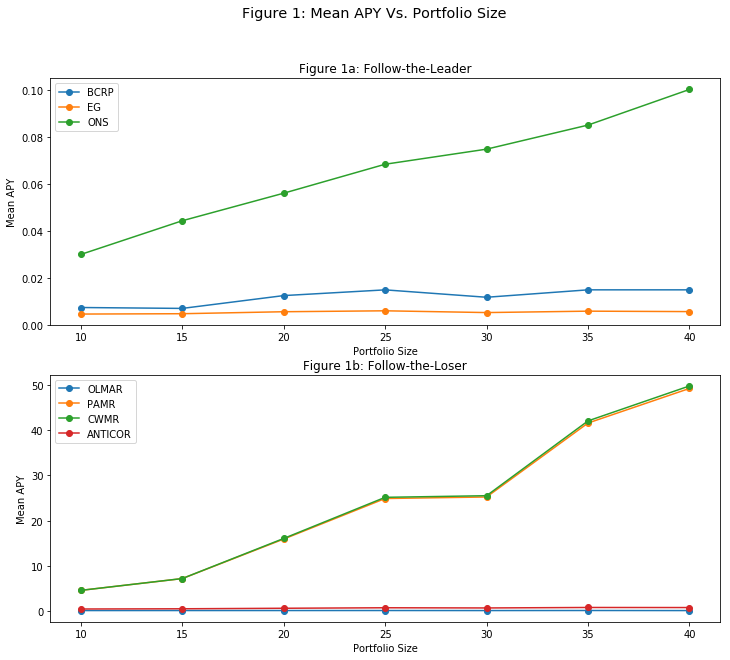

In [44]:
plt.figure(figsize = (12,10))
plt.suptitle('Figure 1: Mean APY Vs. Portfolio Size', fontsize="x-large")
plt.subplot(2,1,1)
plt.plot(portfolio_size, exp1_df['BCRP'], '-o')
plt.plot(portfolio_size, exp1_df['EG'], '-o')
plt.plot(portfolio_size, exp1_df['ONS'], '-o')
plt.title('Figure 1a: Follow-the-Leader')
plt.legend(['BCRP', 'EG', 'ONS'])
plt.xlabel('Portfolio Size')
plt.ylabel('Mean APY')
plt.subplot(2,1,2)
plt.plot(portfolio_size, exp1_df['OLMAR'], '-o')
plt.plot(portfolio_size, exp1_df['PAMR'], '-o')
plt.plot(portfolio_size, exp1_df['CWMR'], '-o')
plt.plot(portfolio_size, exp1_df['ANTICOR'], '-o')
plt.legend(['OLMAR', 'PAMR', 'CWMR', 'ANTICOR'])
plt.xlabel('Portfolio Size')
plt.ylabel('Mean APY')
plt.title('Figure 1b: Follow-the-Loser')
plt.show()
plt.show()

#### Experiment 2: Total Wealth Achieved in a 10 Stock Portfolio 

In [47]:
n_stock = 10
return2_df, price2_df = stock_df(n_stock,start_date,end_date)

Text(0.5,1,'Figure 3: 10 Stock Portfolio')

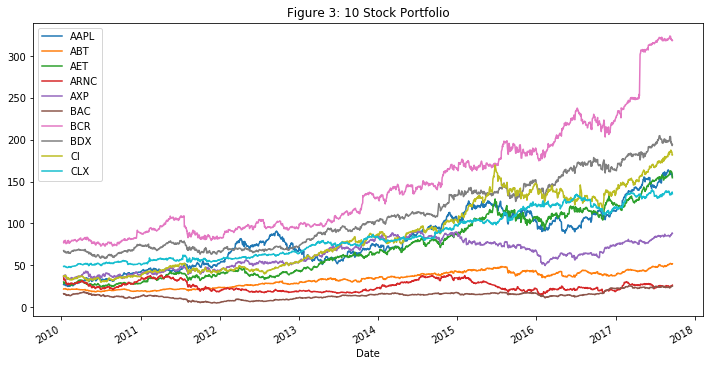

In [48]:
price2_df.plot(figsize = (12,6))
plt.title('Figure 3: 10 Stock Portfolio')

In [49]:
price2_df.columns

Index(['AAPL', 'ABT', 'AET', 'ARNC', 'AXP', 'BAC', 'BCR', 'BDX', 'CI', 'CLX'], dtype='object')

In [50]:
metrics = ['results', 
           'profit', 
           'sharpe', 
           'information_ratio', 
           'annualized_return', 
           'drawdown', 
           'win_pct']

In [51]:
exp2_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [52]:
exp2_df

,results,profit,sharpe,information_ratio,annualized_return,drawdown,win_pct
BCRP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OLMAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CWMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANTICOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    if algorithms[i].PRICE_TYPE =="raw":
        exp2_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(price2_df)
    elif algorithms[i].PRICE_TYPE =="ratio":
        exp2_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(return2_df)
    else:
        exp2_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(return2_df)


2017-12-10 18:26:31,410 Running BCRP...
2017-12-10 18:26:31,448 BCRP finished successfully.
2017-12-10 18:26:31,458 Running EG...
2017-12-10 18:26:31,465 Progress: 0.0%...
2017-12-10 18:26:31,599 Progress: 10.0%...
2017-12-10 18:26:31,717 Progress: 20.0%...
2017-12-10 18:26:31,838 Progress: 30.0%...
2017-12-10 18:26:31,957 Progress: 40.0%...
2017-12-10 18:26:32,078 Progress: 50.0%...
2017-12-10 18:26:32,198 Progress: 60.0%...
2017-12-10 18:26:32,318 Progress: 70.0%...
2017-12-10 18:26:32,437 Progress: 80.0%...
2017-12-10 18:26:32,558 Progress: 90.0%...
2017-12-10 18:26:32,674 EG finished successfully.
2017-12-10 18:26:32,683 Running ONS...
2017-12-10 18:26:32,691 Progress: 0.0%...
2017-12-10 18:26:32,952 Progress: 10.0%...
2017-12-10 18:26:33,183 Progress: 20.0%...
2017-12-10 18:26:33,412 Progress: 30.0%...
2017-12-10 18:26:33,647 Progress: 40.0%...
2017-12-10 18:26:33,900 Progress: 50.0%...
2017-12-10 18:26:34,142 Progress: 60.0%...
2017-12-10 18:26:34,381 Progress: 70.0%...
2017-12-1

In [70]:
def statistics(exp_df):
    '''
    Function that takes as input an experiment data frame and unpacks the results for each algorithm into their 
    respective columns
    '''
    for ind in exp_df.index:
        exp_df.loc[ind, 'profit'] = exp_df.loc[ind, 'results'].profit_factor
        exp_df.loc[ind, 'sharpe'] = exp_df.loc[ind, 'results'].sharpe
        exp_df.loc[ind, 'information_ratio'] = exp_df.loc[ind, 'results'].information
        exp_df.loc[ind, 'annualized_return'] = exp_df.loc[ind, 'results'].annualized_return
        exp_df.loc[ind, 'drawdown'] = exp_df.loc[ind, 'results'].max_drawdown
        exp_df.loc[ind, 'win_pct'] = exp_df.loc[ind, 'results'].winning_pct
    return exp_df

In [118]:
exp2_df = statistics(exp2_df)

In [119]:
def results_plot(exp_df, title, sub_title, figsize):
    '''
    Function that takes as input a data frame of results and produces a 6 panel image containing histograms for the following:
    profit factor, sharpe ratio, information ratio, annualized return, maximum drawdown, and win percentage
    inputs:
    exp_df -- data frame containing experimental results
    title -- main title of image
    sub_title -- titles of subplots (ordered)
    figsize -- size of output image
    '''
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = figsize)
    f.suptitle(title)
    axs = [ax1, ax2, ax3, ax4, ax5, ax6]
    for i in range(len(axs)):
        axs[i].bar(exp_df.index, exp_df.iloc[:,i+1], width = 1.0, color = sns.light_palette("navy", reverse=True))
        axs[i].set_title(sub_title[i])
    plt.show()

In [120]:
exp2_df

,results,profit,sharpe,information_ratio,annualized_return,drawdown,win_pct
BCRP,<universal.result.AlgoResult object at 0x7f6e8...,1.02515,0.140336,0.0682201,0.0400693,0.17381,0.516012
EG,<universal.result.AlgoResult object at 0x7f6e8...,1.02333,0.131528,-4.34791,0.0314259,0.137012,0.518595
ONS,<universal.result.AlgoResult object at 0x7f6e8...,1.17351,0.920246,4.26829,0.238116,0.113453,0.541839
OLMAR,<universal.result.AlgoResult object at 0x7f6e8...,1.03138,0.163088,-0.432178,0.051657,0.475316,0.521603
PAMR,<universal.result.AlgoResult object at 0x7f6e8...,4.32666,7.77548,10.364,27.1144,0.165371,0.729855
CWMR,<universal.result.AlgoResult object at 0x7f6e9...,4.3278,7.79388,10.3855,27.1098,0.165282,0.732955
ANTICOR,<universal.result.AlgoResult object at 0x7f6e8...,2.03345,4.03663,6.0393,2.21565,0.0822555,0.622417


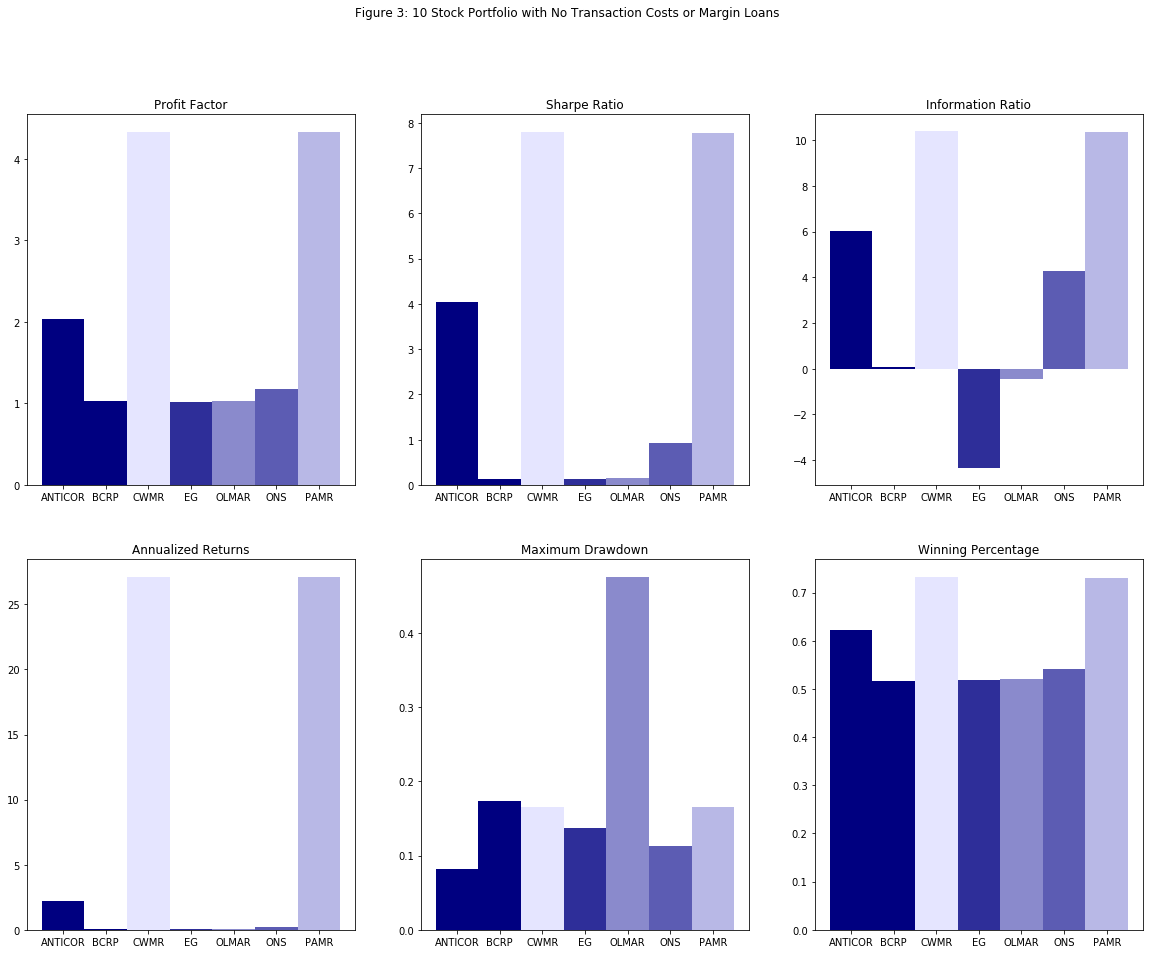

In [121]:
title = 'Figure 3: 10 Stock Portfolio with No Transaction Costs or Margin Loans'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(exp2_df, title = title, sub_title = sub_title, figsize = (20,15))

In [111]:
# will need monthly returns in experiment 3
monthly_return = return2_df
monthly_return = monthly_return.resample('MS').mean()
monthly_price = price2_df
monthly_price = monthly_price.resample('MS').mean()

In [112]:
monthly_results = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [113]:
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    if algorithms[i].PRICE_TYPE =="raw":
        monthly_results.loc[algorithms_col[i], 'results'] = algorithms[i].run(monthly_price)
    else:
        monthly_results.loc[algorithms_col[i], 'results'] = algorithms[i].run(monthly_return)
    

2017-12-10 19:35:08,061 Running BCRP...
2017-12-10 19:35:08,116 BCRP finished successfully.
2017-12-10 19:35:08,122 Running EG...
2017-12-10 19:35:08,128 Progress: 0.0%...
2017-12-10 19:35:08,136 Progress: 10.0%...
2017-12-10 19:35:08,143 Progress: 20.0%...
2017-12-10 19:35:08,150 Progress: 30.0%...
2017-12-10 19:35:08,157 Progress: 40.0%...
2017-12-10 19:35:08,164 Progress: 50.0%...
2017-12-10 19:35:08,172 Progress: 60.0%...
2017-12-10 19:35:08,180 Progress: 70.0%...
2017-12-10 19:35:08,187 Progress: 80.0%...
2017-12-10 19:35:08,194 Progress: 90.0%...
2017-12-10 19:35:08,200 EG finished successfully.
2017-12-10 19:35:08,207 Running ONS...
2017-12-10 19:35:08,216 Progress: 0.0%...
2017-12-10 19:35:08,234 Progress: 10.0%...
2017-12-10 19:35:08,253 Progress: 20.0%...
2017-12-10 19:35:08,267 Progress: 30.0%...
2017-12-10 19:35:08,286 Progress: 40.0%...
2017-12-10 19:35:08,300 Progress: 50.0%...
2017-12-10 19:35:08,316 Progress: 60.0%...
2017-12-10 19:35:08,332 Progress: 70.0%...
2017-12-1

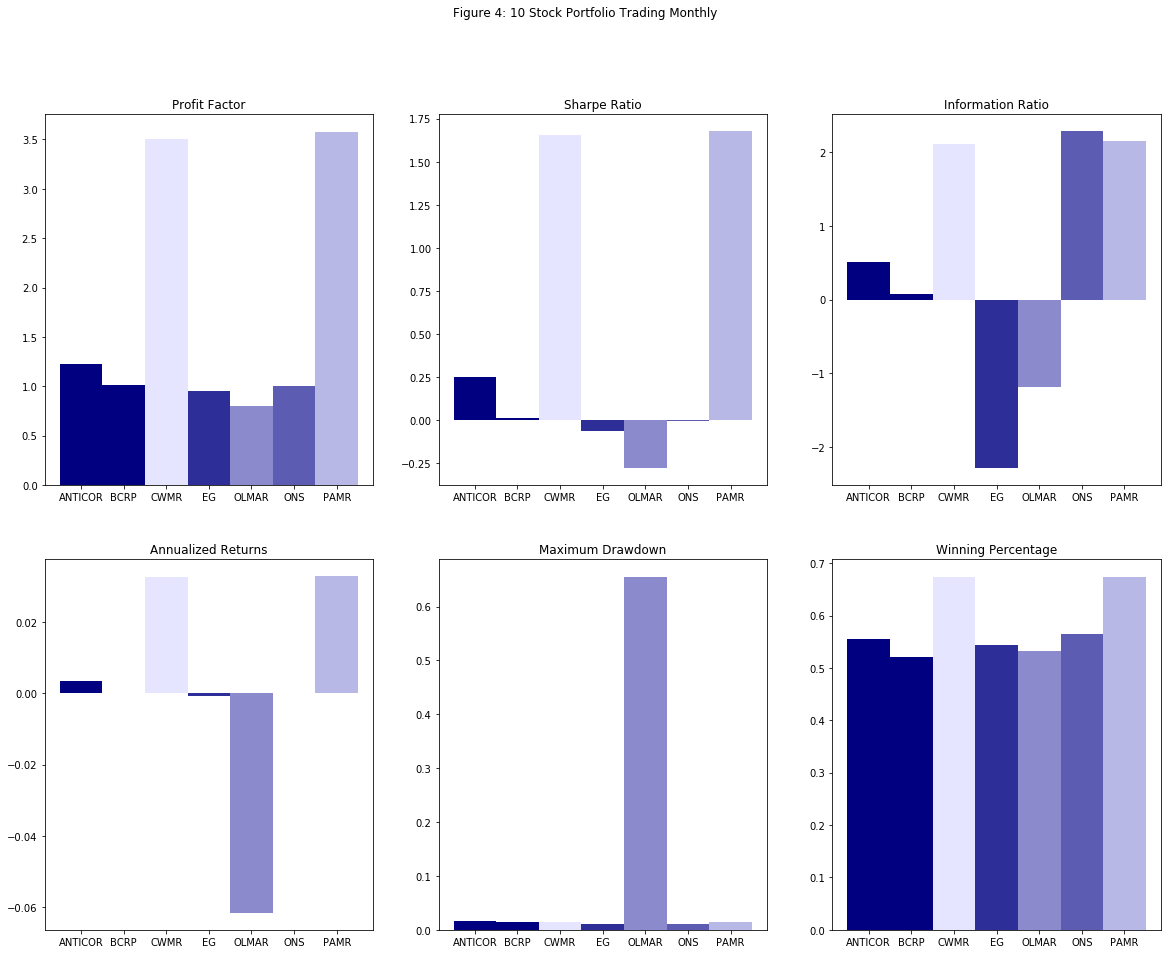

In [114]:
monthly_results = statistics(monthly_results)

title = 'Figure 4: 10 Stock Portfolio Trading Monthly'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(monthly_results, title = title, sub_title = sub_title, figsize = (20,15))

#### Experiment 3: 10 Stocks with Transaction Costs 

In [116]:
# Add fees of 2% per transaction 
for res in exp2_df.results:
    res.fee = 0.00

In [76]:
exp3_df = statistics(exp2_df)

In [104]:
title = 'Figure 5: 10 Stock Portfolio with Transcation Costs'

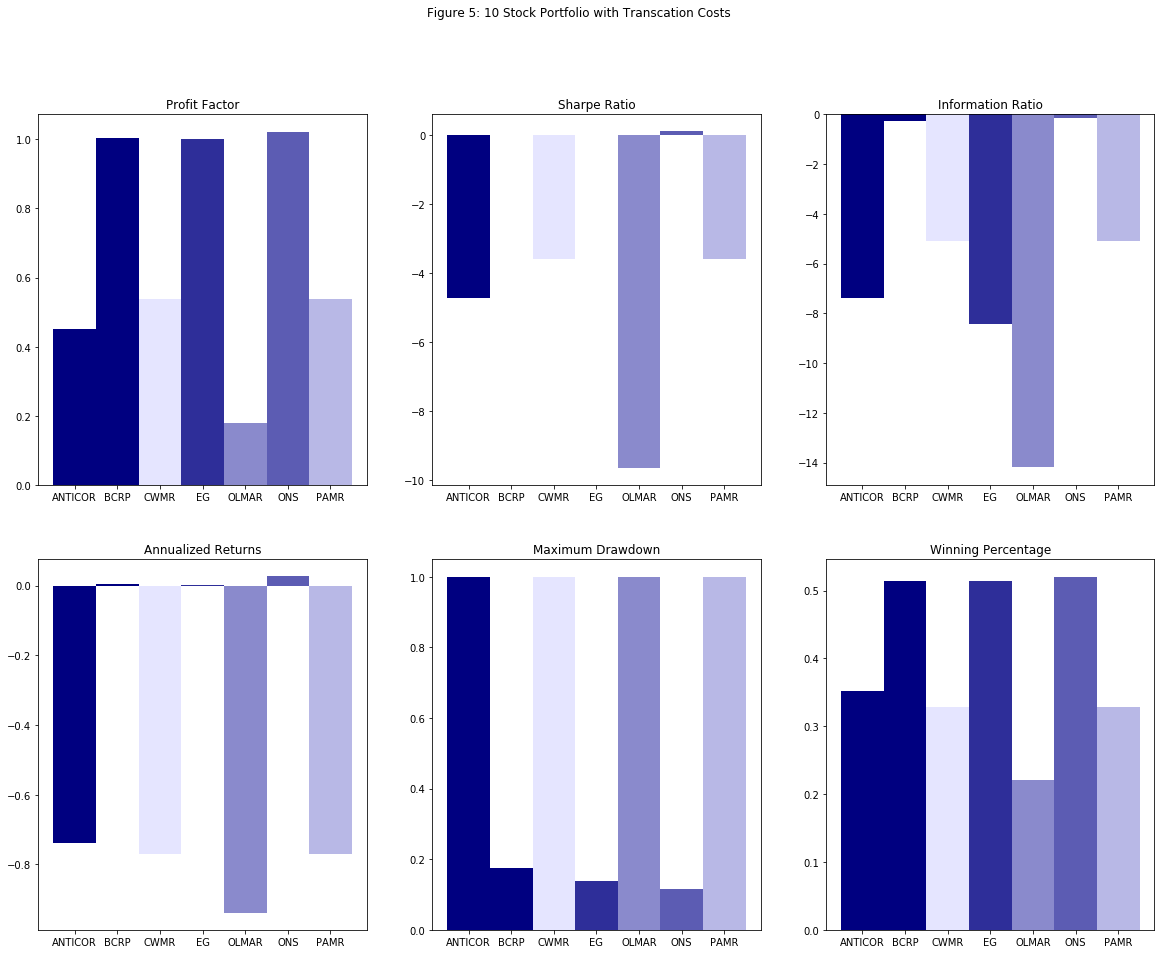

In [105]:
results_plot(exp3_df, title = title, sub_title = sub_title, figsize = (20,15))

#### Experiment 4: Financial Crisis Performance 

In [83]:
n_stocks = 10 
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2011-01-05')
crisis_returns, crisis_prices = stock_df(n_stocks, start_date, end_date)

Text(0.5,1,'Figure 6: Adjusting Closing Prices During 2008-2009 Financial Crisis')

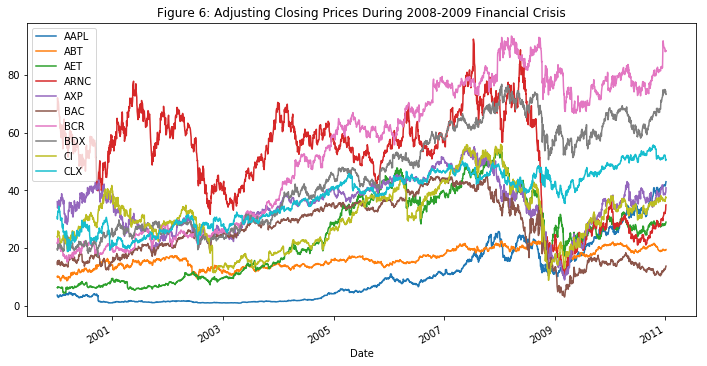

In [84]:
crisis_prices.plot(figsize = (12,6))
plt.title('Figure 6: Adjusting Closing Prices During 2008-2009 Financial Crisis')

In [85]:
exp4_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [86]:
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    if algorithms[i].PRICE_TYPE =="raw":
        exp4_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(crisis_prices)
    elif algorithms[i].PRICE_TYPE =="ratio":
        exp4_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(crisis_returns)
    else:
        exp4_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(crisis_returns)
    

2017-12-10 18:41:13,226 Running BCRP...
2017-12-10 18:41:13,286 BCRP finished successfully.
2017-12-10 18:41:13,297 Running EG...
2017-12-10 18:41:13,305 Progress: 0.0%...
2017-12-10 18:41:13,488 Progress: 10.0%...
2017-12-10 18:41:13,657 Progress: 20.0%...
2017-12-10 18:41:13,829 Progress: 30.0%...
2017-12-10 18:41:14,001 Progress: 40.0%...
2017-12-10 18:41:14,170 Progress: 50.0%...
2017-12-10 18:41:14,349 Progress: 60.0%...
2017-12-10 18:41:14,530 Progress: 70.0%...
2017-12-10 18:41:14,702 Progress: 80.0%...
2017-12-10 18:41:14,875 Progress: 90.0%...
2017-12-10 18:41:15,045 EG finished successfully.
2017-12-10 18:41:15,055 Running ONS...
2017-12-10 18:41:15,062 Progress: 0.0%...
2017-12-10 18:41:15,433 Progress: 10.0%...
2017-12-10 18:41:15,847 Progress: 20.0%...
2017-12-10 18:41:16,260 Progress: 30.0%...
2017-12-10 18:41:16,676 Progress: 40.0%...
2017-12-10 18:41:17,117 Progress: 50.0%...
2017-12-10 18:41:17,571 Progress: 60.0%...
2017-12-10 18:41:18,034 Progress: 70.0%...
2017-12-1

In [87]:
exp4_df = statistics(exp4_df)

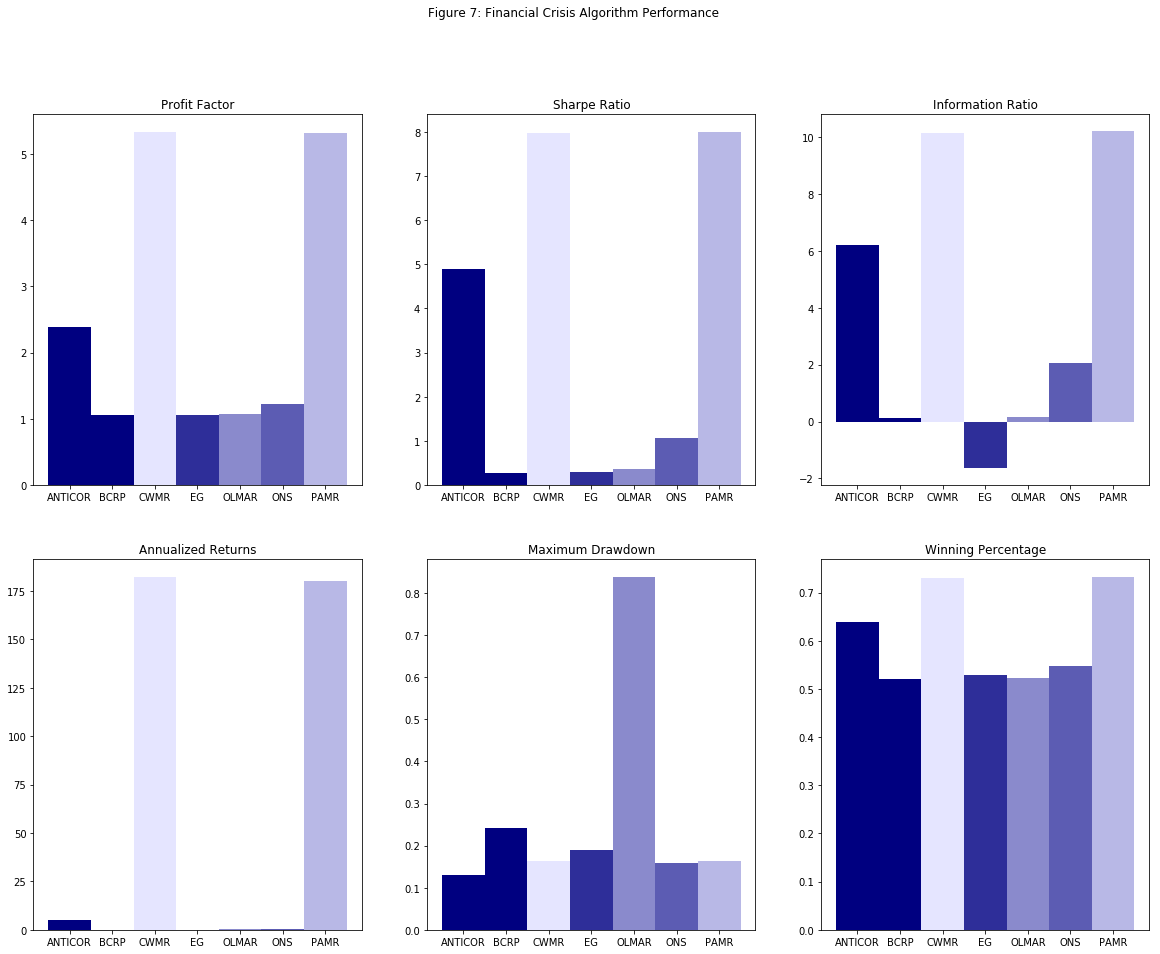

In [89]:
# plot results 
title = 'Figure 7: Financial Crisis Algorithm Performance'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
figsize = (20,15)
results_plot(exp4_df, title= title, sub_title=sub_title, figsize = (20,15))

#### Experiment 5: Tracking the Best Stock - APPL and IBM 

In [92]:
csvs = ['AAPL.csv', 'IBM.csv' ]
start_date = pd.to_datetime('2012-01-10')
end_date = pd.to_datetime('2017-09-20')
return5_df, price5_df = stock_df(n_stocks = 2, start_date= start_date, end_date = end_date, csv = csvs)

Text(0.5,1,'Figure 7: AAPL and IBM Stock Performance')

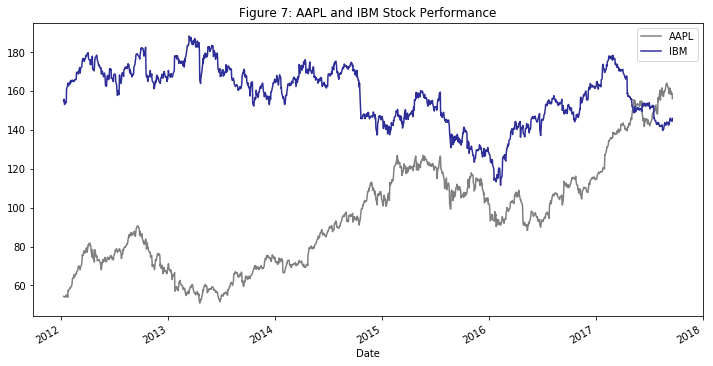

In [93]:
price5_df.plot(color = ['grey', sns.light_palette("navy", reverse=True)[1]] , 
                       figsize = (12,6))
plt.title('Figure 7: AAPL and IBM Stock Performance')

In [94]:
exp5_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [266]:
# run algorithm on returns data 
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    exp5_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(return5_df)

2017-12-07 12:39:38,997 Running BCRP...
2017-12-07 12:39:39,016 BCRP finished successfully.
2017-12-07 12:39:39,033 Running EG...
2017-12-07 12:39:39,045 Progress: 0%...
2017-12-07 12:39:39,301 Progress: 10%...
2017-12-07 12:39:39,509 Progress: 20%...
2017-12-07 12:39:39,720 Progress: 30%...
2017-12-07 12:39:39,923 Progress: 40%...
2017-12-07 12:39:40,119 Progress: 50%...
2017-12-07 12:39:40,329 Progress: 60%...
2017-12-07 12:39:40,535 Progress: 70%...
2017-12-07 12:39:40,740 Progress: 80%...
2017-12-07 12:39:40,940 Progress: 90%...
2017-12-07 12:39:41,141 EG finished successfully.
2017-12-07 12:39:41,157 Running ONS...
2017-12-07 12:39:41,168 Progress: 0%...
2017-12-07 12:39:41,486 Progress: 10%...
2017-12-07 12:39:41,780 Progress: 20%...
2017-12-07 12:39:42,085 Progress: 30%...
2017-12-07 12:39:42,377 Progress: 40%...
2017-12-07 12:39:42,670 Progress: 50%...
2017-12-07 12:39:42,960 Progress: 60%...
2017-12-07 12:39:43,257 Progress: 70%...
2017-12-07 12:39:43,548 Progress: 80%...
2017

In [91]:
# incorporate transcation costs 
for res in exp5_df.results:
    res.fee = 0.01

NameError: name 'exp5_df' is not defined

In [256]:
exp5_df = statistics(exp5_df)

In [332]:
def plot_weights(exp_df, best_stock, title, colors, figsize):
    '''
    Function that takes as input a data frame containing experimental results, image title, and image subtitles and returns 
    graphs that display algorithm weights over the backtest period 
    inputs:
    exp_df -- results of experiment
    best_stock -- ticker of the best stock in the experiment 
    title -- main title over image panel
    subtitle -- image subtitles
    legend -- stock tickers
    '''
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize =figsize)
    f.suptitle(title, y = 1.01, fontsize = 14)
    axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    # plot a common image showing how best stock is tracked 
    for i in range(exp_df.shape[0]):
   #     axs[0].set_color_cycle(sns.light_palette("navy", reverse=True)[1])
        axs[0].plot(exp_df.results[i].weights.loc[:,best_stock], color = sns.light_palette("navy", reverse=True)[1])
        axs[0].set_xlabel('Trading Days')
        axs[0].set_ylabel('Holdings')
        axs[0].set_title('Tracking the Best Stock - ' + best_stock)
    for i in range(1, len(axs)):
        axs[i].set_color_cycle(colors)
        axs[i].plot(exp_df.results[i-1].weights)
        axs[i].set_xlabel('Trading Days')
        axs[i].set_ylabel('Holdings')
        axs[i].set_title(exp_df.index[i-1])
        axs[i].legend(exp_df.results[0].weights.columns)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

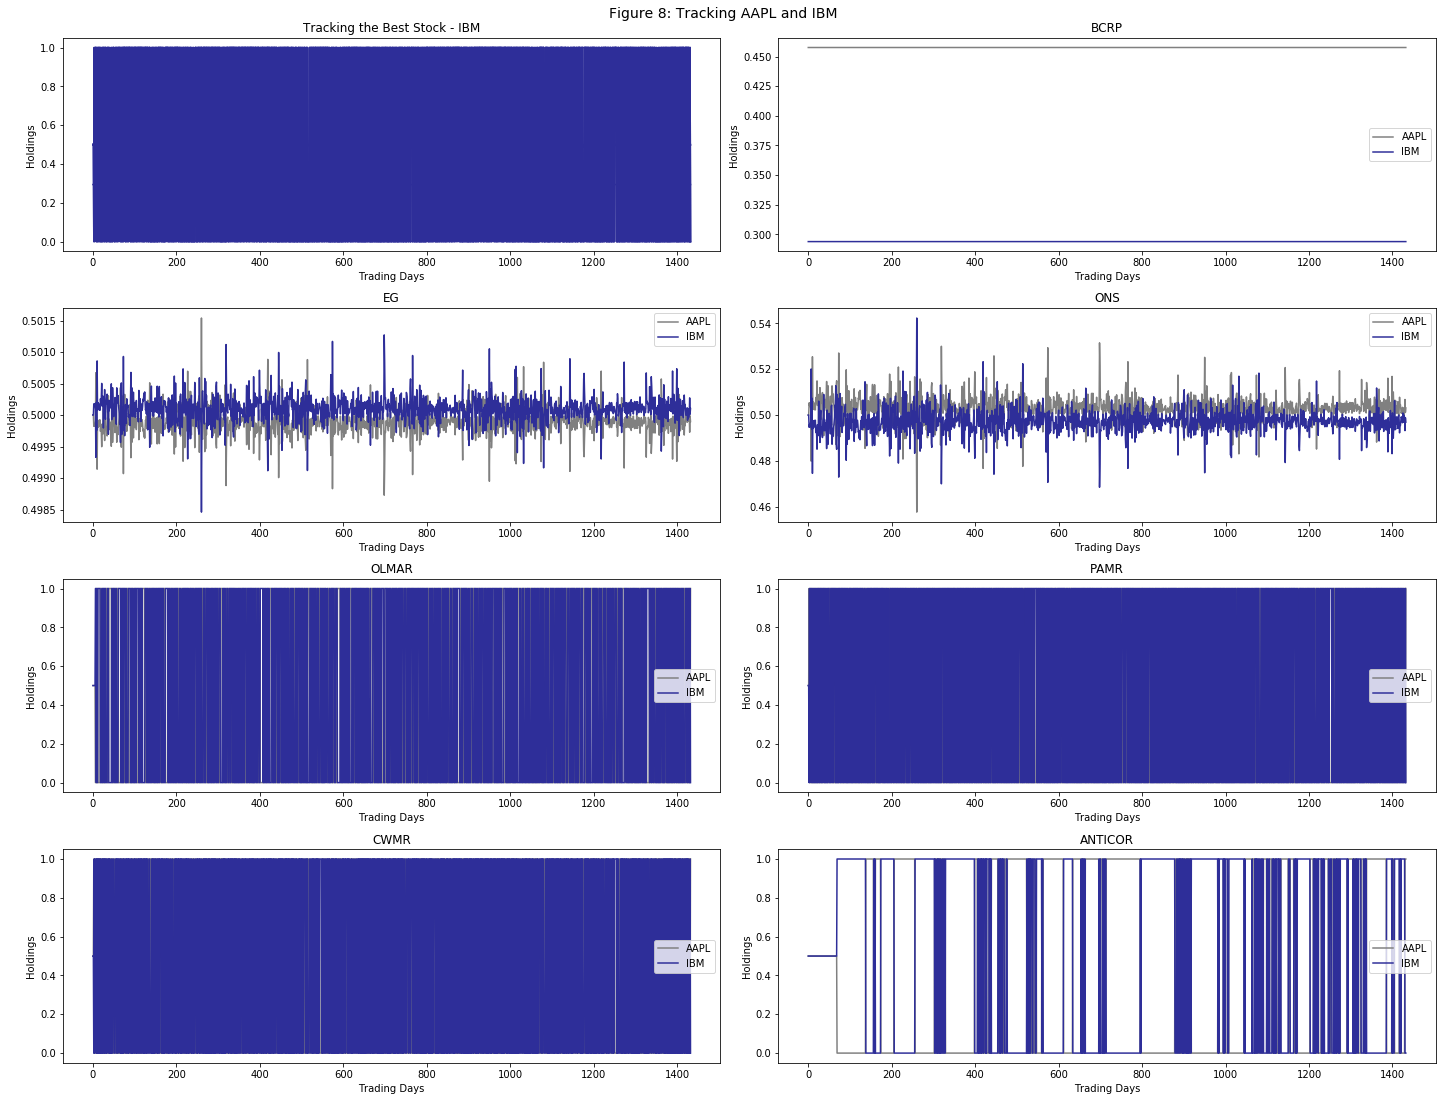

In [333]:
best_stock = 'IBM'
title = 'Figure 8: Tracking AAPL and IBM'
colors = ['grey', sns.light_palette("navy", reverse=True)[1]]
figsize = (20,15)
plot_weights(exp5_df, 
             best_stock = best_stock,
            title = title,
            colors = colors, 
            figsize = figsize)

#### Notes: 
- Major drawback of follow the loser algorithms is clearly that they trade too often. We can include this for illustrative purposes 

#### Experiment 6: Annual Returns for High and Low Volatility Stocks 

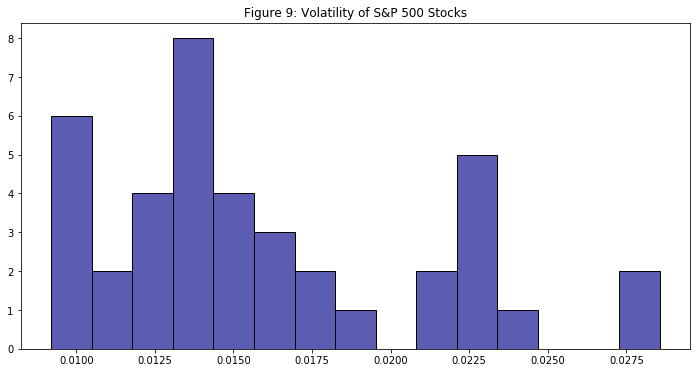

In [351]:
plt.figure(figsize = (12,6))
plt.hist(returns_df.std(axis = 0), bins = 15, ec = 'black', color = sns.light_palette("navy", reverse=True)[2])
plt.title('Figure 9: Volatility of S&P 500 Stocks')
plt.show()

In [100]:
### based on above histogram define a volatility threshold and partition data into high and low volatility data sets
n_stock = 10
high_vol = returns_df.loc[:,returns_df.std() > 0.02]
low_vol = returns_df.loc[:, returns_df.std() <= 0.0125]
low_vol = low_vol.iloc[:,0:n_stock]  # only need ten stocks in each data set 
high_vol = high_vol.iloc[:,0:n_stock]  # only need ten stocks in each data set 
high_vol_prices = price_df.loc[:,returns_df.std() > 0.02]
low_vol_prices = price_df.loc[:, returns_df.std() <= 0.0125]
low_vol_prices = low_vol_prices.iloc[:,0:n_stock]  # only need ten stocks in each data set 
high_vol_prices = high_vol_prices.iloc[:,0:n_stock]  # only need ten stocks in each data set 

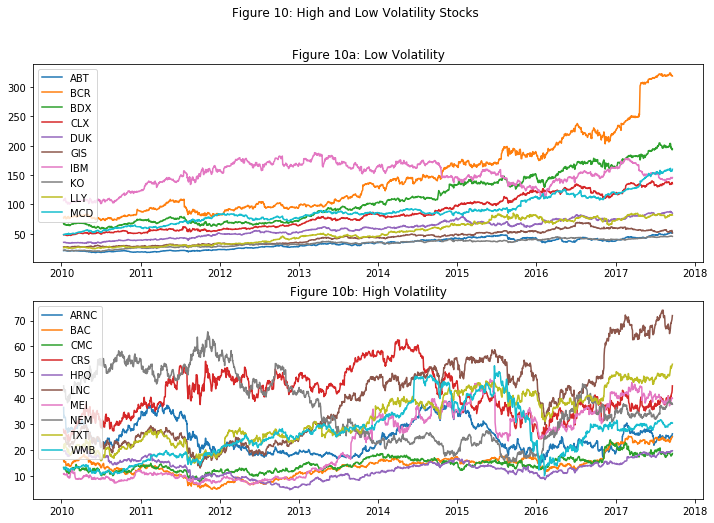

In [101]:
plt.figure(figsize = (12,8))
plt.suptitle('Figure 10: High and Low Volatility Stocks ')
plt.subplot(2,1,1)
plt.plot(price_df.loc[:, low_vol.columns])
plt.title('Figure 10a: Low Volatility')
plt.legend(low_vol.columns)
plt.subplot(2,1,2)
plt.plot(price_df.loc[:, high_vol.columns])
plt.title('Figure 10b: High Volatility')
plt.legend(high_vol.columns)
plt.show()

In [102]:
low_vol_res = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)
high_vol_res = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [103]:
# run main for loop on low and high volatility data sets 
for i in range(len(algorithms_col)):
    if algorithms[i].PRICE_TYPE =="raw":
        low_vol_res.loc[algorithms_col[i], 'results'] = algorithms[i].run(low_vol_prices)
        high_vol_res.loc[algorithms_col[i], 'results'] = algorithms[i].run(high_vol_prices)
    else:
        low_vol_res.loc[algorithms_col[i], 'results'] = algorithms[i].run(low_vol)
        high_vol_res.loc[algorithms_col[i], 'results'] = algorithms[i].run(high_vol)
    

2017-12-10 18:52:04,362 Running BCRP...
2017-12-10 18:52:04,403 BCRP finished successfully.
2017-12-10 18:52:04,415 Running BCRP...
2017-12-10 18:52:04,459 BCRP finished successfully.
2017-12-10 18:52:04,469 Running EG...
2017-12-10 18:52:04,476 Progress: 0.0%...
2017-12-10 18:52:04,610 Progress: 10.0%...
2017-12-10 18:52:04,728 Progress: 20.0%...
2017-12-10 18:52:04,847 Progress: 30.0%...
2017-12-10 18:52:04,965 Progress: 40.0%...
2017-12-10 18:52:05,085 Progress: 50.0%...
2017-12-10 18:52:05,206 Progress: 60.0%...
2017-12-10 18:52:05,325 Progress: 70.0%...
2017-12-10 18:52:05,444 Progress: 80.0%...
2017-12-10 18:52:05,563 Progress: 90.0%...
2017-12-10 18:52:05,681 EG finished successfully.
2017-12-10 18:52:05,689 Running EG...
2017-12-10 18:52:05,694 Progress: 0.0%...
2017-12-10 18:52:05,813 Progress: 10.0%...
2017-12-10 18:52:05,932 Progress: 20.0%...
2017-12-10 18:52:06,050 Progress: 30.0%...
2017-12-10 18:52:06,168 Progress: 40.0%...
2017-12-10 18:52:06,287 Progress: 50.0%...
2017

In [106]:
low_vol_res = statistics(low_vol_res)
high_vol_res = statistics(high_vol_res)

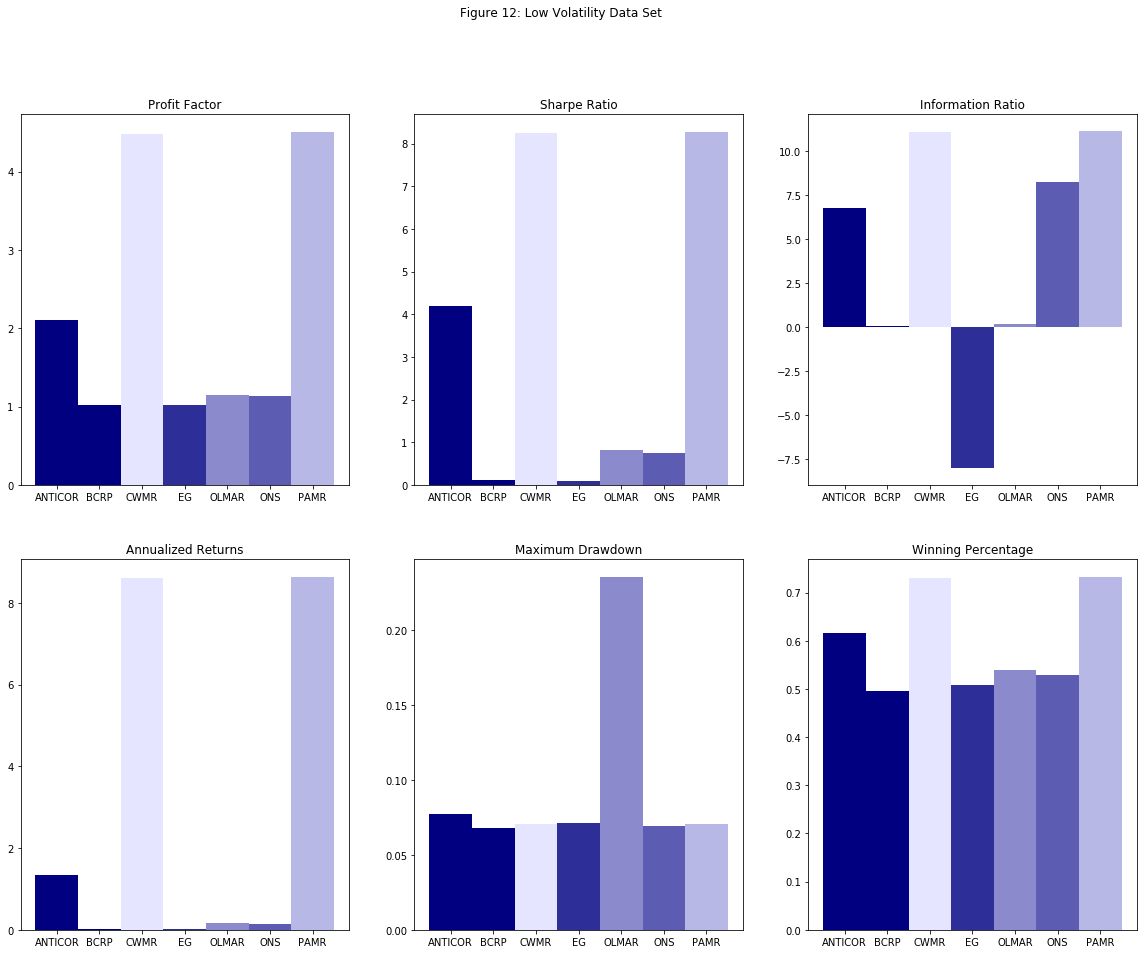

In [107]:
# plot results : low_vol_res, high_vol_res 
title = 'Figure 12: Low Volatility Data Set'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(low_vol_res, title = title, sub_title = sub_title, figsize = (20,15))

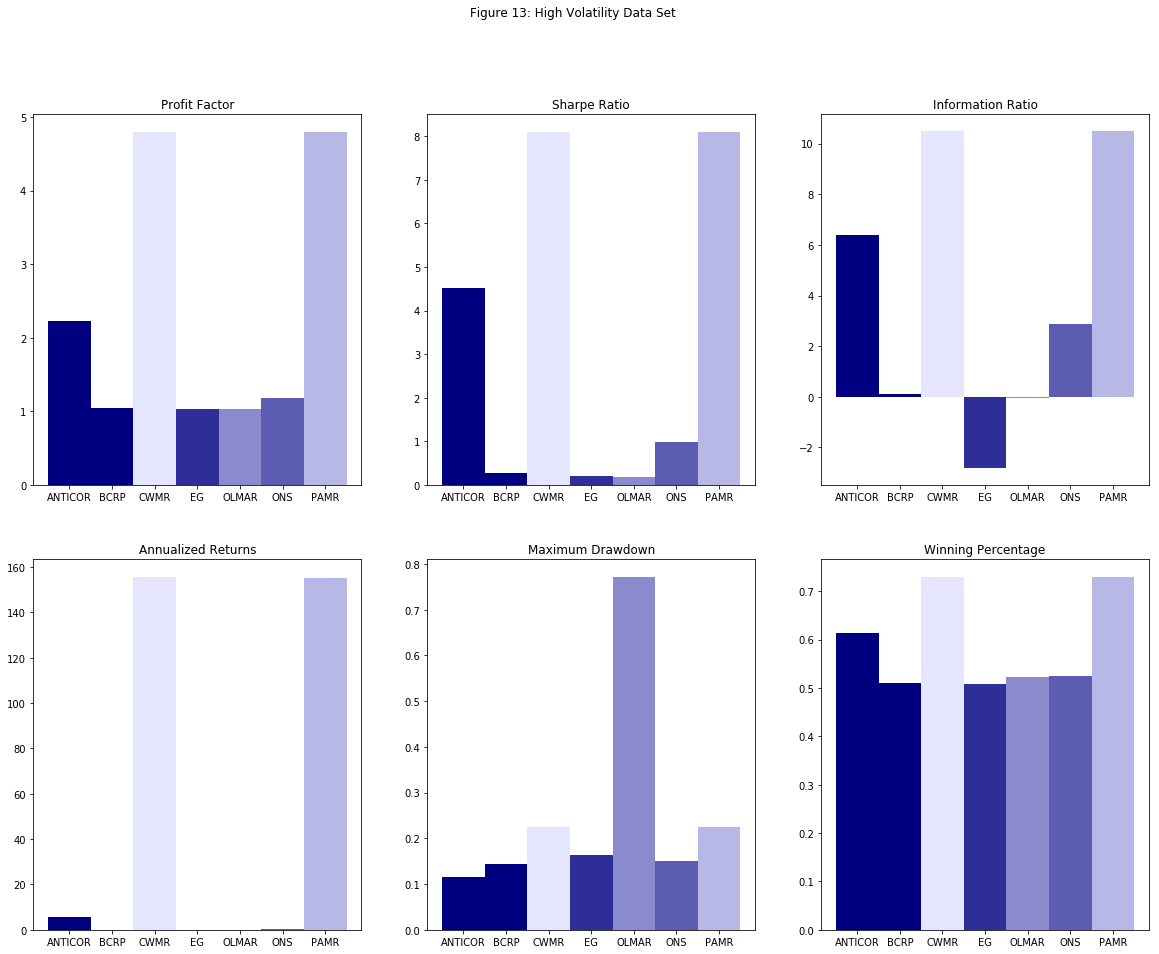

In [108]:
title = 'Figure 13: High Volatility Data Set'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(high_vol_res, title = title, sub_title = sub_title, figsize = (20,15))